# Contexte

Nous nous trouvons actuellement chez Cars&Co. Alex, ingénieur, est en charge de la maintenance des systèmes de production au sein de l'entreprise. 

Les automates s'occupant de l'assemblage des véhicules tombent régulièrement en panne et le temps nécessaire à leur maintenance est conséquent, principalement en raison des délais de livraison des pièces de rechange. Il s'agit de bras robotisés d'une valeur de 5000€ chacun et leur coût de maintenance peut aller jusque 3000€. De plus, la panne d'une machine bloque la chaîne de production entraînant une perte pouvant s'élever à 15% des bénéfices de l'entreprise.

Pour palier à ce problème, Alex fait appel à Paula, data scientist, qui lui propose de développer un algorithme de Machine Learning capable d'anticiper les pannes des machines. Cette application permettra de commander à l'avance les pièces de remplacement ce qui assurera au responsable de production une disponibilité certaine de ces pièces en cas de panne. 

Dans la suite de ce document, nous présenterons les grandes étapes de développement du modèle analytique, de l'analyse des données issues des capteurs à l'évaluation de la performance de l'algorithme.

# Predictive maintenance
Ce notebook a pour but de predire la durée de vie de machines industrielles.

Ce notebook utilise le jeu de donnée suivant: https://www.kaggle.com/nafisur/dataset-for-predictive-maintenance

La méthodologie de résolution du probleme est inspiré de : https://gallery.azure.ai/Experiment/Predictive-Maintenance-Step-1-of-3-data-preparation-and-feature-engineering-2

Le notebook est organisé de la maniere suivante:
    
        0- CHARGEMENT DES PACKAGES ET DEFINITION DES FONCTIONS
    
        1-TRAIN DATA
            1-a Chargement des données
            1-b Feature engineering
            1-c Target definition
        
        2- TEST DATA
            2-a Chargement des données
            2-b Feature engineering
            2-c Target definition
        
        3- ESTIMATION DES MOMENTS D'ORDRE SUPERIEUR
        
        4- MODELISATION
            4.1 Données désequilibrées
                4.1.a Régression logistique multiclasses
                4.1.b Modèle Keras
                4.1.c Test avec Random Forest
                4.1.d KNN Classification
            4.2 Données équilibrées
                4.2.a Régression logistique multiclasses
                4.2.b Modèle Keras 
                4.2.c Test avec Random Forest
                4.2.d KNN Classification
            
         5- COMPARATEUR D'ALGORITHMES 
         
         

## 0- CHARGEMENT DES PACKAGES ET DEFINITION DES FONCTIONS

In [1]:
#### Packages Management ####
import pandas as pd
import seaborn as sns #Affichage des matrices de confusion
import matplotlib.pyplot as plt #Pour tout ce qui est affichage de graphique
import matplotlib.transforms 
from datetime import datetime
import numpy as np
from sklearn import metrics, linear_model, datasets, model_selection 
from imblearn.over_sampling import SMOTE  #Pour l'oversampling des données
import tensorflow as tf 
from keras import models,layers,optimizers #Création et entraînement des réseaux de neurones
from keras.layers import Dense, Dropout, LSTM, Activation, Embedding  #Création et entraînement des réseaux de neurones
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score #Calculs de précision, construction des matrices de confusion
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.io import arff
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn import svm #support vector Machine
from scipy.stats import moment #Calcul des moments d'ordre supérieur
import warnings 

warnings.filterwarnings('ignore')  #Hide all warnings
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

Using TensorFlow backend.


In [2]:
#Décommenter pour avoir les versions des packages utilisés

# import sklearn as sk
# import matplotlib as matp
# import imblearn as im
# import keras as ker
# import scipy as scy

# print('Version imblearn : ',im.__version__)
# print('Version scikit-learn : ',sk.__version__)
# print('Version keras : ',ker.__version__)
# print('Version scipy : ',scy.__version__)
# print('Version tensorflow : ',tf.__version__)
# print('Version seaborn : ',sns.__version__)
# print('Version matplotlib : ',matp.__version__) 

La fonction ci-après permet de définir les paramètres du graphique qui nous permettra d'observer l'ipmportance des coefficients associés à chaque paramètre de nos sets de données dans le cas de la Régression Logistique. 

In [3]:
def plot_feature_coeffs(classifier,feature_names,features_coeff_to_plot):
    coef = classifier.coef_[0] 

    n_top_features=int(0.5*features_coeff_to_plot*len(feature_names))
    pos_coeffs = np.argsort(coef)[-n_top_features:]
    neg_coeffs = np.argsort(coef)[:n_top_features]
    relevant_coeffs = np.hstack([neg_coeffs,pos_coeffs])

    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[relevant_coeffs]]
    plt.bar(np.arange(2*n_top_features), coef[relevant_coeffs], color=colors)
    plt.subplots_adjust(bottom=0.3)
    
    plt.xticks(np.arange(1, 2 * n_top_features), feature_names[relevant_coeffs], rotation=60, ha="right")
    plt.xlabel("Feature name")
    plt.ylabel("Feature magnitude\n(Regression coeff)")
    plt.show()

La fonction ci-après permet de définir les paramètres du graphique qui nous permettra d'observer l'ipmportance des coefficients associés à chaque paramètre de nos sets de données dans le cas du Random Forest.

In [4]:
def plot_feature_coeffs_spec(classifier,feature_names,features_coeff_to_plot):
    coef = classifier.feature_importances_ 

    n_top_features=int(0.5*features_coeff_to_plot*len(feature_names))
    pos_coeffs = np.argsort(coef)[-n_top_features:]
    neg_coeffs = np.argsort(coef)[:n_top_features]
    relevant_coeffs = np.hstack([neg_coeffs,pos_coeffs])

    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[relevant_coeffs]]
    plt.bar(np.arange(2*n_top_features), coef[relevant_coeffs], color=colors)
    plt.subplots_adjust(bottom=0.3)
    
    plt.xticks(np.arange(1, 2 * n_top_features), feature_names[relevant_coeffs], rotation=60, ha="right")
    plt.xlabel("Feature name")
    plt.ylabel("Feature magnitude\n(Regression coeff)")
    plt.show()

In [5]:
#Lorsque vous passez d'un PC à un autre, changez le chemin d'accès à vos différents fichiers dans cette variable
#Veillez, cependant à bien les stocker dans le même répertoire pour faciliter les accès.

path="C:/Users/belemva/Desktop/PSA_predictive/Data_source/"  

## 1-TRAIN
Cette section permet de preparer le jeu d'entrainement (train) qu'on utilisera dans un second temps pour entrainer les modèles de prédiction.

### 1-a Chargement des données

In [6]:
# On utilise la librarie pandas pour charger les données à partir d'un fichier .txt . D'autres formats (csv, excel...) peuvent aussi être pris en compte
DF= pd.read_csv(path+"PM_train.txt", header=None ,sep = " ")

#On supprime la limitation du nombre de colonnes visualisées.
pd.options.display.max_columns = None 

#Les deux dernieres colonnes numerotées 26 et 27 sont majoriterement vides et n'apporte aucune information supplémentaires. Donc nous les supprimons.
DF=DF.drop([26,27],axis=1)
DF.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [7]:
# Statistiques descriptives de base pour vérifier la cohérence des données
DF.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,553.367711,2388.096652,9065.242941,1.3,47.541168,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,0.001389,0.885092,0.070985,22.082880,0.0,0.267087,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,1.3,46.850000,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,552.810000,2388.050000,9053.100000,1.3,47.350000,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,553.440000,2388.090000,9060.660000,1.3,47.510000,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,554.010000,2388.140000,9069.420000,1.3,47.700000,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,1.3,48.530000,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


### 1-b Feature engineering
Dans cette section, nous allons créer de nouvelles variables. 
La premiere étape consiste à introduire des variables pouvant expliquer notre variable cible Y (variable à predire).

In [8]:
# Nous créeons deux variables:
#  la moyenne glissante sur 5 cycles
#  L'écart-type glissant sur 5 cycles
#  Ces deux variables glissantes sont créées pour l'ensemble des indicateurs sensoriels (colonnes 5 à 26)

for i in (range(5,26)):
    title='Rolling_average_sensor_'+str(i)
    title2='Rolling_std_sensor_'+str(i)
    DF[title]= DF.groupby(0)[i].rolling(window=5,min_periods=1).mean().reset_index(level=0, drop=True)
    DF[title2]= DF.groupby(0)[i].rolling(window=5,min_periods=1).std().reset_index(level=0, drop=True)

DF.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,Rolling_average_sensor_5,Rolling_std_sensor_5,Rolling_average_sensor_6,Rolling_std_sensor_6,Rolling_average_sensor_7,Rolling_std_sensor_7,Rolling_average_sensor_8,Rolling_std_sensor_8,Rolling_average_sensor_9,Rolling_std_sensor_9,Rolling_average_sensor_10,Rolling_std_sensor_10,Rolling_average_sensor_11,Rolling_std_sensor_11,Rolling_average_sensor_12,Rolling_std_sensor_12,Rolling_average_sensor_13,Rolling_std_sensor_13,Rolling_average_sensor_14,Rolling_std_sensor_14,Rolling_average_sensor_15,Rolling_std_sensor_15,Rolling_average_sensor_16,Rolling_std_sensor_16,Rolling_average_sensor_17,Rolling_std_sensor_17,Rolling_average_sensor_18,Rolling_std_sensor_18,Rolling_average_sensor_19,Rolling_std_sensor_19,Rolling_average_sensor_20,Rolling_std_sensor_20,Rolling_average_sensor_21,Rolling_std_sensor_21,Rolling_average_sensor_22,Rolling_std_sensor_22,Rolling_average_sensor_23,Rolling_std_sensor_23,Rolling_average_sensor_24,Rolling_std_sensor_24,Rolling_average_sensor_25,Rolling_std_sensor_25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,518.67,NaN,641.820000,NaN,1589.700000,NaN,1400.600000,NaN,14.62,NaN,21.61,NaN,554.360000,NaN,2388.0600,NaN,9046.190000,NaN,1.3,NaN,47.470,NaN,521.660,NaN,2388.020,NaN,8138.620000,NaN,8.419500,NaN,0.03,NaN,392.000000,NaN,2388.0,NaN,100.0,NaN,39.060000,NaN,23.419000,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,518.67,0.0,641.985000,0.233345,1590.760000,1.499066,1401.870000,1.796051,14.62,0.0,21.61,0.0,554.055000,0.431335,2388.0500,0.014142,9045.130000,1.499066,1.3,0.0,47.480,0.014142,521.970,0.438406,2388.045,0.035355,8135.055000,5.041671,8.425650,0.008697,0.03,0.0,392.000000,0.000000,2388.0,0.0,100.0,0.0,39.030000,0.042426,23.421300,0.003253
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,518.67,0.0,642.106667,0.267644,1589.836667,1.918654,1402.646667,1.850009,14.62,0.0,21.61,0.0,554.123333,0.327159,2388.0600,0.020000,9047.733333,4.632023,1.3,0.0,47.410,0.121655,522.120,0.404475,2388.040,0.026458,8134.446667,3.717450,8.423033,0.007640,0.03,0.0,391.333333,1.154701,2388.0,0.0,100.0,0.0,39.003333,0.055076,23.395600,0.044573
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,518.67,0.0,642.167500,0.250117,1588.075000,3.855909,1402.452500,1.559645,14.62,0.0,21.61,0.0,554.205000,0.313103,2388.0725,0.029861,9048.170000,3.881555,1.3,0.0,47.340,0.171659,522.305,0.495950,2388.050,0.029439,8134.292500,3.050906,8.409325,0.028117,0.03,0.0,391.500000,1.000000,2388.0,0.0,100.0,0.0,38.972500,0.076322,23.390175,0.037977
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,518.67,0.0,642.208000,0.234776,1587.030000,4.075678,1403.206000,2.159440,14.62,0.0,21.61,0.0,554.164000,0.286234,2388.0700,0.026458,9049.566000,4.587366,1.3,0.0,47.328,0.151063,522.282,0.432574,2388.048,0.025884,8134.194000,2.651326,8.413340,0.025953,0.03,0.0,391.800000,1.095445,2388.0,0.0,100.0,0.0,38.958000,0.073621,23.393020,0.033498


### 1-c Target definition
Nous allons définir notre variable cible Y (target ou variable à predire).

Pour chaque machine (dont l'id est unique), nous avons en notre possesion l'information du nombre de cycles total que la machine a réalisé avant de tomber en panne.

L'objectif est donc de rendre cette information utilisable par nos modèles de prédiction. Dans l'optique d'utiliser une classification supervisée, nous allons répartir les lignes selon le nombre de cycle restant.

La première étape consiste à deduire le nombre de cycle restant à partir du nombre de cycle total (RUL_max) et du nombre de cycles déjà effectués. On obtient ainsi la colonne "RUL" qui represente le nombre de cycles restants à la machine à un instant t.

La deuxième étape est la mise en place d'une répartition selon le nombre cycles restants (RUL). Pour effectuer cette répartition, nous avons décidé de créer 3 classes :

        - classe 0 : RUL<15 , en d'autres termes, la machine est susceptible de tomber en panne dans 15 cycles ou moins
        - classe 1 : 15<RUL<30 , en d'autres termes, la machine tombera en panne dans 30 cycles ou moins 
        - classe 2 : 30<RUL , en d'autres termes, la machine tombera en panne dans plus de 30 cycles

In [9]:
RUL=pd.DataFrame(list(range(0,101))) #Le dataframe RUL contient le rul_max ou cycle de vie maximal d'une machine
RUL['rul_max']=DF.groupby(0)[1].max()
RUL=RUL.drop([0],axis = 0)

In [10]:
DF_RUL_nan=DF.merge(RUL, left_on=0, right_on=0) #On fusionne notre jeu de donées avec le dataframe RUL créer
DF_RUL_nan.head(10) #On obtient, ainsi, pour chaque machine, le nombre estimé de cycle restant avant la panne (colonne 'RUL')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,Rolling_average_sensor_5,Rolling_std_sensor_5,Rolling_average_sensor_6,Rolling_std_sensor_6,Rolling_average_sensor_7,Rolling_std_sensor_7,Rolling_average_sensor_8,Rolling_std_sensor_8,Rolling_average_sensor_9,Rolling_std_sensor_9,Rolling_average_sensor_10,Rolling_std_sensor_10,Rolling_average_sensor_11,Rolling_std_sensor_11,Rolling_average_sensor_12,Rolling_std_sensor_12,Rolling_average_sensor_13,Rolling_std_sensor_13,Rolling_average_sensor_14,Rolling_std_sensor_14,Rolling_average_sensor_15,Rolling_std_sensor_15,Rolling_average_sensor_16,Rolling_std_sensor_16,Rolling_average_sensor_17,Rolling_std_sensor_17,Rolling_average_sensor_18,Rolling_std_sensor_18,Rolling_average_sensor_19,Rolling_std_sensor_19,Rolling_average_sensor_20,Rolling_std_sensor_20,Rolling_average_sensor_21,Rolling_std_sensor_21,Rolling_average_sensor_22,Rolling_std_sensor_22,Rolling_average_sensor_23,Rolling_std_sensor_23,Rolling_average_sensor_24,Rolling_std_sensor_24,Rolling_average_sensor_25,Rolling_std_sensor_25,rul_max
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,518.67,NaN,641.820000,NaN,1589.700000,NaN,1400.600000,NaN,14.62,NaN,21.61,NaN,554.360000,NaN,2388.0600,NaN,9046.190000,NaN,1.3,NaN,47.470,NaN,521.660,NaN,2388.020,NaN,8138.620000,NaN,8.419500,NaN,0.03,NaN,392.000000,NaN,2388.0,NaN,100.0,NaN,39.060000,NaN,23.419000,NaN,192.0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,518.67,0.0,641.985000,0.233345,1590.760000,1.499066,1401.870000,1.796051,14.62,0.0,21.61,0.0,554.055000,0.431335,2388.0500,0.014142,9045.130000,1.499066,1.3,0.0,47.480,0.014142,521.970,0.438406,2388.045,0.035355,8135.055000,5.041671,8.425650,0.008697,0.03,0.0,392.000000,0.000000,2388.0,0.0,100.0,0.0,39.030000,0.042426,23.421300,0.003253,192.0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,518.67,0.0,642.106667,0.267644,1589.836667,1.918654,1402.646667,1.850009,14.62,0.0,21.61,0.0,554.123333,0.327159,2388.0600,0.020000,9047.733333,4.632023,1.3,0.0,47.410,0.121655,522.120,0.404475,2388.040,0.026458,8134.446667,3.717450,8.423033,0.007640,0.03,0.0,391.333333,1.154701,2388.0,0.0,100.0,0.0,39.003333,0.055076,23.395600,0.044573,192.0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,518.67,0.0,642.167500,0.250117,1588.075000,3.855909,1402.452500,1.559645,14.62,0.0,21.61,0.0,554.205000,0.313103,2388.0725,0.029861,9048.170000,3.881555,1.3,0.0,47.340,0.171659,522.305,0.495950,2388.050,0.029439,8134.292500,3.050906,8.409325,0.028117,0.03,0.0,391.500000,1.000000,2388.0,0.0,100.0,0.0,38.972500,0.076322,23.390175,0.037977,192.0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,518.67,0.0,642.208000,0.234776,1587.030000,4.075678,1403.206000,2.159440,14.62,0.0,21.61,0.0,554.164000,0.286234,2388.0700,0.026458,9049.566000,4.587366,1.3,0.0,47.328,0.151063,522.282,0.432574,2388.048,0.025884,8134.194000,2.651326,8.413340,0.025953,0.03,0.0,391.800000,1.095445,2388.0,0.0,100.0,0.0,38.958000,0.073621,23.393020,0.033498,192.0
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,21.61,554.67,2388.02,9049.68,1.3,47.16,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669,518.67,0.0,642.264000,0.128374,1585.984000,3.885831,1402.760000,2.926337,14.62,0.0,21.61,0.0,554.226000,0.362671,2388.0620,0.034928,9050.264000,4.193904,1.3,0.0,47.266,0.141527,522.286,0.425417,2388.050,0.023452,8133.040000,0.958697,8.411600,0.025727,0.03,0.0,391.600000,1

In [11]:
for i in range(len(DF_RUL_nan)):
    DF_RUL_nan.loc[i,"RUL"]=DF_RUL_nan.loc[i,"rul_max"]-DF_RUL_nan.loc[i,1] #La colonne 1 du jeu de données indique le nombre de cycles écoulés
DF_RUL_nan.head(10) #On obtient, ainsi, pour chaque machine, le nombre de cycle total de fonctionnement (colonne 'rul_max')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,Rolling_average_sensor_5,Rolling_std_sensor_5,Rolling_average_sensor_6,Rolling_std_sensor_6,Rolling_average_sensor_7,Rolling_std_sensor_7,Rolling_average_sensor_8,Rolling_std_sensor_8,Rolling_average_sensor_9,Rolling_std_sensor_9,Rolling_average_sensor_10,Rolling_std_sensor_10,Rolling_average_sensor_11,Rolling_std_sensor_11,Rolling_average_sensor_12,Rolling_std_sensor_12,Rolling_average_sensor_13,Rolling_std_sensor_13,Rolling_average_sensor_14,Rolling_std_sensor_14,Rolling_average_sensor_15,Rolling_std_sensor_15,Rolling_average_sensor_16,Rolling_std_sensor_16,Rolling_average_sensor_17,Rolling_std_sensor_17,Rolling_average_sensor_18,Rolling_std_sensor_18,Rolling_average_sensor_19,Rolling_std_sensor_19,Rolling_average_sensor_20,Rolling_std_sensor_20,Rolling_average_sensor_21,Rolling_std_sensor_21,Rolling_average_sensor_22,Rolling_std_sensor_22,Rolling_average_sensor_23,Rolling_std_sensor_23,Rolling_average_sensor_24,Rolling_std_sensor_24,Rolling_average_sensor_25,Rolling_std_sensor_25,rul_max,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,518.67,NaN,641.820000,NaN,1589.700000,NaN,1400.600000,NaN,14.62,NaN,21.61,NaN,554.360000,NaN,2388.0600,NaN,9046.190000,NaN,1.3,NaN,47.470,NaN,521.660,NaN,2388.020,NaN,8138.620000,NaN,8.419500,NaN,0.03,NaN,392.000000,NaN,2388.0,NaN,100.0,NaN,39.060000,NaN,23.419000,NaN,192.0,191.0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,518.67,0.0,641.985000,0.233345,1590.760000,1.499066,1401.870000,1.796051,14.62,0.0,21.61,0.0,554.055000,0.431335,2388.0500,0.014142,9045.130000,1.499066,1.3,0.0,47.480,0.014142,521.970,0.438406,2388.045,0.035355,8135.055000,5.041671,8.425650,0.008697,0.03,0.0,392.000000,0.000000,2388.0,0.0,100.0,0.0,39.030000,0.042426,23.421300,0.003253,192.0,190.0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,518.67,0.0,642.106667,0.267644,1589.836667,1.918654,1402.646667,1.850009,14.62,0.0,21.61,0.0,554.123333,0.327159,2388.0600,0.020000,9047.733333,4.632023,1.3,0.0,47.410,0.121655,522.120,0.404475,2388.040,0.026458,8134.446667,3.717450,8.423033,0.007640,0.03,0.0,391.333333,1.154701,2388.0,0.0,100.0,0.0,39.003333,0.055076,23.395600,0.044573,192.0,189.0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,518.67,0.0,642.167500,0.250117,1588.075000,3.855909,1402.452500,1.559645,14.62,0.0,21.61,0.0,554.205000,0.313103,2388.0725,0.029861,9048.170000,3.881555,1.3,0.0,47.340,0.171659,522.305,0.495950,2388.050,0.029439,8134.292500,3.050906,8.409325,0.028117,0.03,0.0,391.500000,1.000000,2388.0,0.0,100.0,0.0,38.972500,0.076322,23.390175,0.037977,192.0,188.0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,518.67,0.0,642.208000,0.234776,1587.030000,4.075678,1403.206000,2.159440,14.62,0.0,21.61,0.0,554.164000,0.286234,2388.0700,0.026458,9049.566000,4.587366,1.3,0.0,47.328,0.151063,522.282,0.432574,2388.048,0.025884,8134.194000,2.651326,8.413340,0.025953,0.03,0.0,391.800000,1.095445,2388.0,0.0,100.0,0.0,38.958000,0.073621,23.393020,0.033498,192.0,187.0
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,21.61,554.67,2388.02,9049.68,1.3,47.16,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669,518.67,0.0,642.264000,0.128374,1585.984000,3.885831,1402.760000,2.926337,14.62,0.0,21.61,0.0,554.226000,0.362671,2388.0620,0.034928,9050.264000,4.193904,1.3,0.0,47.266,0.141527,522.286,0.425417,2388.050,0.023452,8133.040000,0.958697,8.411

In [12]:
#À partir de la colonne 'RUL' établie, nous pouvons donc construire la colonne 'Target' dans laquelle nous affecterons 
#un numéro de classe (celles définies précédemment : 0, 1 ou 2) en fonction de la valeur du RUL.

for i in range(len(DF_RUL_nan)):
    if DF_RUL_nan.loc[i,"RUL"]<=15:
        DF_RUL_nan.loc[i,"Target"]= 0
    elif DF_RUL_nan.loc[i,"RUL"]<=30:
        DF_RUL_nan.loc[i,"Target"]= 1
    else:
        DF_RUL_nan.loc[i,"Target"]= 2

Ici, nous allons supprimer les lignes NaN du jeu de données. En effet, les lignes NaN sont inexploitables dans notre cas et, penser changer les NaN en 0 fausserait nos prédictions. Il faut donc retirer ces lignes du jeu de données en gardant à l'esprit que le pourcentages de lignes supprimées n'excède pas les 5% . Si c'est le cas, alors là nous pourront transformer les NaN en 0. Il faut donc :
   
    1- Vérifier le pourcentage de lignes NaN dans le dataframe;
    2- Supprimer les lignes NaN s'il n'y en a pas plus de 5% dans le fichier, les remplacer par 0 s'il y en a plus de 5%;
    3- Comprarer le nombre de lignes dans le dataframe initial et le nombre de lignes dans le dataframe sans les NaN.

N.B.: remplacer les NaN par 0 n'est pas une pratique conseillée. Il faudrait plutôt effectuer une prédiction de ces valeurs à partir des données contenues dans le dataframe.

In [13]:
nan_lines=sum([True for idx,row in DF_RUL_nan.iterrows() if any(row.isnull())]) #On fait la somme de toutes les lignes NaN contenues dans le dataframe
percent_nan = (nan_lines/len(DF_RUL_nan))*100 #Déterminons le pourcentage qu'elles représentent dans le dataframe
print("Pourcentage de lignes contenant des valeurs NaN dans le dataframe :",percent_nan,"%")

Pourcentage de lignes contenant des valeurs NaN dans le dataframe : 0.48470747903640155 %


In [14]:
if percent_nan < 5:
    DF_RUL = DF_RUL_nan.dropna(how='any')
    
#Le pourcentage de lignes NaN étant très largement inférieur à 5%, nous pouvons donc supprimer ces lignes de notre dataframe

In [15]:
print("Nombre de lignes dans le fichier initial :",len(DF_RUL_nan))
print("Nombre de lignes dans le fichier sans NaN :",len(DF_RUL)) #On observe si le nombre de lignes supprimées est flagrant

Nombre de lignes dans le fichier initial : 20631
Nombre de lignes dans le fichier sans NaN : 20531


In [16]:
DF_RUL.rename(columns={0: 'id_machine', 1: 'Cycle', 2: 'Parameter 1', 3: 'Parameter 2', 4: 'Parameter 3', 5: 'Sensor 5', 6: 'Sensor 6', 7: 'Sensor 7', 8: 'Sensor 8', 9: 'Sensor 9', 10: 'Sensor 10', 11: 'Sensor 11', 12: 'Sensor 12', 13: 'Sensor 13', 14: 'Sensor 14', 15: 'Sensor 15', 16: 'Sensor 16', 17: 'Sensor 17', 18: 'Sensor 18', 19: 'Sensor 19', 20: 'Sensor 20', 21: 'Sensor 21', 22: 'Sensor 22', 23: 'Sensor 23', 24: 'Sensor 24', 25: 'Sensor 25'}, inplace=True)
#Nous renommons les premières colonnes du dataframe avec des noms plus significatifs et précis

In [17]:
DF_RUL.head(10)

,id_machine,Cycle,Parameter 1,Parameter 2,Parameter 3,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,Sensor 10,Sensor 11,Sensor 12,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Sensor 22,Sensor 23,Sensor 24,Sensor 25,Rolling_average_sensor_5,Rolling_std_sensor_5,Rolling_average_sensor_6,Rolling_std_sensor_6,Rolling_average_sensor_7,Rolling_std_sensor_7,Rolling_average_sensor_8,Rolling_std_sensor_8,Rolling_average_sensor_9,Rolling_std_sensor_9,Rolling_average_sensor_10,Rolling_std_sensor_10,Rolling_average_sensor_11,Rolling_std_sensor_11,Rolling_average_sensor_12,Rolling_std_sensor_12,Rolling_average_sensor_13,Rolling_std_sensor_13,Rolling_average_sensor_14,Rolling_std_sensor_14,Rolling_average_sensor_15,Rolling_std_sensor_15,Rolling_average_sensor_16,Rolling_std_sensor_16,Rolling_average_sensor_17,Rolling_std_sensor_17,Rolling_average_sensor_18,Rolling_std_sensor_18,Rolling_average_sensor_19,Rolling_std_sensor_19,Rolling_average_sensor_20,Rolling_std_sensor_20,Rolling_average_sensor_21,Rolling_std_sensor_21,Rolling_average_sensor_22,Rolling_std_sensor_22,Rolling_average_sensor_23,Rolling_std_sensor_23,Rolling_average_sensor_24,Rolling_std_sensor_24,Rolling_average_sensor_25,Rolling_std_sensor_25,rul_max,RUL,Target
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,518.67,0.0,641.985000,0.233345,1590.760000,1.499066,1401.870000,1.796051,14.62,0.0,21.61,0.0,554.055000,0.431335,2388.0500,0.014142,9045.130000,1.499066,1.3,0.0,47.480,0.014142,521.970,0.438406,2388.045,0.035355,8135.055000,5.041671,8.425650,0.008697,0.03,0.0,392.000000,0.000000,2388.0,0.0,100.0,0.0,39.030000,0.042426,23.421300,0.003253,192.0,190.0,2.0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,518.67,0.0,642.106667,0.267644,1589.836667,1.918654,1402.646667,1.850009,14.62,0.0,21.61,0.0,554.123333,0.327159,2388.0600,0.020000,9047.733333,4.632023,1.3,0.0,47.410,0.121655,522.120,0.404475,2388.040,0.026458,8134.446667,3.717450,8.423033,0.007640,0.03,0.0,391.333333,1.154701,2388.0,0.0,100.0,0.0,39.003333,0.055076,23.395600,0.044573,192.0,189.0,2.0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,518.67,0.0,642.167500,0.250117,1588.075000,3.855909,1402.452500,1.559645,14.62,0.0,21.61,0.0,554.205000,0.313103,2388.0725,0.029861,9048.170000,3.881555,1.3,0.0,47.340,0.171659,522.305,0.495950,2388.050,0.029439,8134.292500,3.050906,8.409325,0.028117,0.03,0.0,391.500000,1.000000,2388.0,0.0,100.0,0.0,38.972500,0.076322,23.390175,0.037977,192.0,188.0,2.0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,518.67,0.0,642.208000,0.234776,1587.030000,4.075678,1403.206000,2.159440,14.62,0.0,21.61,0.0,554.164000,0.286234,2388.0700,0.026458,9049.566000,4.587366,1.3,0.0,47.328,0.151063,522.282,0.432574,2388.048,0.025884,8134.194000,2.651326,8.413340,0.025953,0.03,0.0,391.800000,1.095445,2388.0,0.0,100.0,0.0,38.958000,0.073621,23.393020,0.033498,192.0,187.0,2.0
5,1,6,-0.0043,-0.0001,100.0,518.67,642.10,1584.47,1398.37,14.62,21.61,554.67,2388.02,9049.68,1.3,47.16,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100.0,38.98,23.3669,518.67,0.0,642.264000,0.128374,1585.984000,3.885831,1402.760000,2.926337,14.62,0.0,21.61,0.0,554.226000,0.362671,2388.0620,0.034928,9050.264000,4.193904,1.3,0.0,47.266,0.141527,522.286,0.425417,2388.050,0.023452,8133.040000,0.958697,8.411600,0.025727,0.03,0.0,391.600000,1.140175,2388.0,0.0,100.0,0.0,38.942000,0.051186,23.382600,0.031436,192.0,186.0,2.0
6,1,7,0.0010,0.0001,100.0,518.67,642.48,1592.32,1397.77,14.62,21.61,554.34,2388.02,9059.13,1.3,47.36,522.32,2388.03,81

À présent, observons la réparttion des données dans chacune des classes que nous avons créées.

In [18]:
DF_RUL['Target'].value_counts() #Observons la balance des données réparties dans les classes correspondantes

2.0    17431
0.0     1600
1.0     1500
Name: Target, dtype: int64

<function matplotlib.pyplot.show(*args, **kw)>

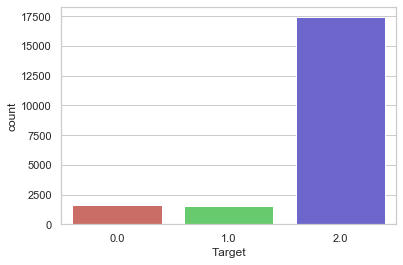

In [19]:
sns.countplot(x='Target', data=DF_RUL, palette = 'hls')
plt.show

In [20]:
count_0 = len(DF_RUL[DF_RUL['Target']==0])
count_1 = len(DF_RUL[DF_RUL['Target']==1])
count_2 = len(DF_RUL[DF_RUL['Target']==2])

pct_of_target_0 = count_0/(count_0+count_1+count_2)
print("percentage of target 0 is", pct_of_target_0*100,"%")
pct_of_target_1 = count_1/(count_0+count_1+count_2)
print("percentage of target 1 is", pct_of_target_1*100,"%")
pct_of_target_2 = count_2/(count_0+count_1+count_2)
print("percentage of target 2 is", pct_of_target_2*100,"%")

percentage of target 0 is 7.7930933709999515 %
percentage of target 1 is 7.306025035312453 %
percentage of target 2 is 84.9008815936876 %


Les 3 précédents résultats montrent qu'il y a une forte prépondérance des données dans notre classe 2. En utilisant un tel jeu de données pour construire notre modèle, nous n'aurons pas de résultats vraiment pertinents puisque l'IA prédira par défaut la classe 2 étant donné qu'elle aura 84% de chances d'avoir juste dans ses prédictions. Il faut donc égaliser les données. Nous ferons cela dans la partie 3 de notre Notebook.

## 2- TEST DATA

Cette Section est dédiée à la préparation de notre jeu de données test qui servira à tester nos modèles de prédictions dans la partie suivante. Globalement, les étapes sont similaires à celles du traitement du jeu de données d'entraînement.

### 2-a Chargement des données

In [21]:
#### Chargement des données en entrée ####
DF_test= pd.read_csv(path+"PM_test.txt", header=None ,sep = " ")
pd.options.display.max_columns = None 
DF_test=DF_test.drop([26,27],axis=1) #Ces 2 colonnes sont vides
DF_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


### 2-b Feature engineering

In [22]:
# Nous créeons deux variables:
#  la moyenne glissante sur 5 cycles
#  L'ecart-type grlissant sur 5 cycles
#  Ces deux variables glissantes sont créées pour l'ensemble des indicateurs sensoriels (colonnes 5 à 26)

for i in (range(5,26)):
    title='Rolling_average_sensor_'+str(i)
    title2='Rolling_std_sensor_'+str(i)
    DF_test[title]= DF_test.groupby(0)[i].rolling(window=5,min_periods=1).mean().reset_index(level=0, drop=True)
    DF_test[title2]= DF_test.groupby(0)[i].rolling(window=5,min_periods=1).std().reset_index(level=0, drop=True)
    
DF_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,Rolling_average_sensor_5,Rolling_std_sensor_5,Rolling_average_sensor_6,Rolling_std_sensor_6,Rolling_average_sensor_7,Rolling_std_sensor_7,Rolling_average_sensor_8,Rolling_std_sensor_8,Rolling_average_sensor_9,Rolling_std_sensor_9,Rolling_average_sensor_10,Rolling_std_sensor_10,Rolling_average_sensor_11,Rolling_std_sensor_11,Rolling_average_sensor_12,Rolling_std_sensor_12,Rolling_average_sensor_13,Rolling_std_sensor_13,Rolling_average_sensor_14,Rolling_std_sensor_14,Rolling_average_sensor_15,Rolling_std_sensor_15,Rolling_average_sensor_16,Rolling_std_sensor_16,Rolling_average_sensor_17,Rolling_std_sensor_17,Rolling_average_sensor_18,Rolling_std_sensor_18,Rolling_average_sensor_19,Rolling_std_sensor_19,Rolling_average_sensor_20,Rolling_std_sensor_20,Rolling_average_sensor_21,Rolling_std_sensor_21,Rolling_average_sensor_22,Rolling_std_sensor_22,Rolling_average_sensor_23,Rolling_std_sensor_23,Rolling_average_sensor_24,Rolling_std_sensor_24,Rolling_average_sensor_25,Rolling_std_sensor_25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,518.67,NaN,643.020000,NaN,1585.290000,NaN,1398.210000,NaN,14.62,NaN,21.61,NaN,553.900000,NaN,2388.040000,NaN,9050.170,NaN,1.3,NaN,47.200,NaN,521.7200,NaN,2388.0300,NaN,8125.550000,NaN,8.405200,NaN,0.03,NaN,392.000000,NaN,2388.0,NaN,100.0,NaN,38.860000,NaN,23.37350,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,518.67,0.0,642.365000,0.926310,1586.870000,2.234457,1396.815000,1.972828,14.62,0.0,21.61,0.0,554.375000,0.671751,2388.025000,0.021213,9052.295,3.005204,1.3,0.0,47.350,0.212132,521.9400,0.311127,2388.0450,0.021213,8132.585000,9.948992,8.392750,0.017607,0.03,0.0,392.500000,0.707107,2388.0,0.0,100.0,0.0,38.940000,0.113137,23.38255,0.012799
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,518.67,0.0,642.396667,0.657292,1586.893333,1.580517,1398.323333,2.961627,14.62,0.0,21.61,0.0,554.286667,0.499032,2388.033333,0.020817,9053.850,3.430700,1.3,0.0,47.400,0.173205,521.9500,0.220681,2388.0400,0.017321,8131.756667,7.179807,8.409867,0.032155,0.03,0.0,392.666667,0.577350,2388.0,0.0,100.0,0.0,38.986667,0.113725,23.39390,0.021642
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,518.67,0.0,642.407500,0.537114,1586.200000,1.894254,1400.347500,4.715558,14.62,0.0,21.61,0.0,554.232500,0.421614,2388.032500,0.017078,9051.710,5.115160,1.3,0.0,47.370,0.153623,521.8075,0.337182,2388.0425,0.015000,8132.042500,5.890096,8.405325,0.027781,0.03,0.0,392.250000,0.957427,2388.0,0.0,100.0,0.0,38.990000,0.093095,23.38885,0.020353
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,518.67,0.0,642.428000,0.467408,1586.398000,1.699167,1400.662000,4.143902,14.62,0.0,21.61,0.0,554.218000,0.366565,2388.028000,0.017889,9050.278,5.465965,1.3,0.0,47.358,0.135720,521.8760,0.329742,2388.0400,0.014142,8131.542000,5.222300,8.404880,0.024080,0.03,0.0,391.800000,1.303840,2388.0,0.0,100.0,0.0,38.990000,0.080623,23.39368,0.020672


### 2-c Target definition

La définition de la variable cible change, ici, par rapport à la partie 1. En effet, nous disposons, en plus du jeu de données test, d'un dataframe contenant le nombre de cycles avant panne estimé (rul_last) pour chaque machine. Dans le dataframe de test nous retrouvons la valeur du dernier cycle (donc le nombre de cycle total avant panne) durant lequel chaque machine a fonctionné après tests (cycle_last). Le nombre de cycles de vie maximal (rul_max) de chaque machine équivaut donc à la somme entre le nombre de cycles avant panne estimé et la valeur du dernier cycle de vie obtenu après test pour chaque machine. 

In [23]:
target= pd.read_csv(path+"PM_truth.txt", header=None ,sep = " ")
pd.options.display.max_columns = None 
target=target.drop([1],axis = 1)
target[1]=list(range(1,(len(target)+1)))
cycle_last=pd.DataFrame(DF_test.groupby(0)[1].max())
cycle_last.reset_index(drop=True, inplace=True)
target[2]=cycle_last
target.head() #Dataframe contenant le nombre de cycles avant panne estimé

,0,1,2
0,112,1,31
1,98,2,49
2,69,3,126
3,82,4,106
4,91,5,98


In [24]:
DF_RUL_test_nan=DF_test.merge(target, left_on=0, right_on=1)
DF_RUL_test_nan=DF_RUL_test_nan.drop(['key_0','1_y'],axis = 1)
DF_RUL_test_nan.rename(columns={'0_x':'0'}, inplace=True)
DF_RUL_test_nan.rename(columns={'1_x':'1'}, inplace=True)
DF_RUL_test_nan.rename(columns={'0_y':'rul_last'}, inplace=True)
DF_RUL_test_nan.rename(columns={'2_y':'cycle_last'}, inplace=True)
DF_RUL_test_nan['rul_max']=DF_RUL_test_nan['rul_last']+DF_RUL_test_nan['cycle_last']
DF_RUL_test_nan.head(10)

,0,1,2_x,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,Rolling_average_sensor_5,Rolling_std_sensor_5,Rolling_average_sensor_6,Rolling_std_sensor_6,Rolling_average_sensor_7,Rolling_std_sensor_7,Rolling_average_sensor_8,Rolling_std_sensor_8,Rolling_average_sensor_9,Rolling_std_sensor_9,Rolling_average_sensor_10,Rolling_std_sensor_10,Rolling_average_sensor_11,Rolling_std_sensor_11,Rolling_average_sensor_12,Rolling_std_sensor_12,Rolling_average_sensor_13,Rolling_std_sensor_13,Rolling_average_sensor_14,Rolling_std_sensor_14,Rolling_average_sensor_15,Rolling_std_sensor_15,Rolling_average_sensor_16,Rolling_std_sensor_16,Rolling_average_sensor_17,Rolling_std_sensor_17,Rolling_average_sensor_18,Rolling_std_sensor_18,Rolling_average_sensor_19,Rolling_std_sensor_19,Rolling_average_sensor_20,Rolling_std_sensor_20,Rolling_average_sensor_21,Rolling_std_sensor_21,Rolling_average_sensor_22,Rolling_std_sensor_22,Rolling_average_sensor_23,Rolling_std_sensor_23,Rolling_average_sensor_24,Rolling_std_sensor_24,Rolling_average_sensor_25,Rolling_std_sensor_25,rul_last,cycle_last,rul_max
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,518.67,NaN,643.020000,NaN,1585.290000,NaN,1398.210000,NaN,14.62,NaN,21.61,NaN,553.900000,NaN,2388.040000,NaN,9050.170,NaN,1.3,NaN,47.200,NaN,521.7200,NaN,2388.0300,NaN,8125.550000,NaN,8.405200,NaN,0.03,NaN,392.000000,NaN,2388.0,NaN,100.0,NaN,38.860000,NaN,23.37350,NaN,112,31,143
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,518.67,0.0,642.365000,0.926310,1586.870000,2.234457,1396.815000,1.972828,14.62,0.0,21.61,0.0,554.375000,0.671751,2388.025000,0.021213,9052.295,3.005204,1.3,0.0,47.350,0.212132,521.9400,0.311127,2388.0450,0.021213,8132.585000,9.948992,8.392750,0.017607,0.03,0.0,392.500000,0.707107,2388.0,0.0,100.0,0.0,38.940000,0.113137,23.38255,0.012799,112,31,143
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,518.67,0.0,642.396667,0.657292,1586.893333,1.580517,1398.323333,2.961627,14.62,0.0,21.61,0.0,554.286667,0.499032,2388.033333,0.020817,9053.850,3.430700,1.3,0.0,47.400,0.173205,521.9500,0.220681,2388.0400,0.017321,8131.756667,7.179807,8.409867,0.032155,0.03,0.0,392.666667,0.577350,2388.0,0.0,100.0,0.0,38.986667,0.113725,23.39390,0.021642,112,31,143
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,518.67,0.0,642.407500,0.537114,1586.200000,1.894254,1400.347500,4.715558,14.62,0.0,21.61,0.0,554.232500,0.421614,2388.032500,0.017078,9051.710,5.115160,1.3,0.0,47.370,0.153623,521.8075,0.337182,2388.0425,0.015000,8132.042500,5.890096,8.405325,0.027781,0.03,0.0,392.250000,0.957427,2388.0,0.0,100.0,0.0,38.990000,0.093095,23.38885,0.020353,112,31,143
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,518.67,0.0,642.428000,0.467408,1586.398000,1.699167,1400.662000,4.143902,14.62,0.0,21.61,0.0,554.218000,0.366565,2388.028000,0.017889,9050.278,5.465965,1.3,0.0,47.358,0.135720,521.8760,0.329742,2388.0400,0.014142,8131.542000,5.222300,8.404880,0.024080,0.03,0.0,391.800000,1.303840,2388.0,0.0,100.0,0.0,38.990000,0.080623,23.39368,0.020672,112,31,143
5,1,6,0.0012,0.0003,100.0,518.67,642.11,1579.12,1395.13,14.62,21.61,554.22,2388.00,9050.96,1.3,47.26,521.92,2388.08,8127.46,8.4238,0.03,392,2388,100.0,38.91,23.3467,518.67,0.0,642.246000,0.338718,1585.164000,3.730835,1400.046000,4.779674,14.62,0.0,21.61,0.0,554.282000,0.322444,2388.020000,0.020000,9050.436,5.473475,1.3,0.0,47.370,0.120000,521.9160,0.318009,2388.0500,0.021213,8131.924000,4.7201

Les étapes suivantes sont identiques à celles de la mise en place de la colonne RUL et de la suppression des lignes contenant un NaN effectuées lors du traitement de jeu de données d'entraînement.

In [25]:
for i in range(len(DF_RUL_test_nan)):
    DF_RUL_test_nan.loc[i,"RUL"]=(DF_RUL_test_nan.loc[i,'rul_max']-DF_RUL_test_nan.iloc[i,1])
DF_RUL_test_nan.head(10)

,0,1,2_x,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,Rolling_average_sensor_5,Rolling_std_sensor_5,Rolling_average_sensor_6,Rolling_std_sensor_6,Rolling_average_sensor_7,Rolling_std_sensor_7,Rolling_average_sensor_8,Rolling_std_sensor_8,Rolling_average_sensor_9,Rolling_std_sensor_9,Rolling_average_sensor_10,Rolling_std_sensor_10,Rolling_average_sensor_11,Rolling_std_sensor_11,Rolling_average_sensor_12,Rolling_std_sensor_12,Rolling_average_sensor_13,Rolling_std_sensor_13,Rolling_average_sensor_14,Rolling_std_sensor_14,Rolling_average_sensor_15,Rolling_std_sensor_15,Rolling_average_sensor_16,Rolling_std_sensor_16,Rolling_average_sensor_17,Rolling_std_sensor_17,Rolling_average_sensor_18,Rolling_std_sensor_18,Rolling_average_sensor_19,Rolling_std_sensor_19,Rolling_average_sensor_20,Rolling_std_sensor_20,Rolling_average_sensor_21,Rolling_std_sensor_21,Rolling_average_sensor_22,Rolling_std_sensor_22,Rolling_average_sensor_23,Rolling_std_sensor_23,Rolling_average_sensor_24,Rolling_std_sensor_24,Rolling_average_sensor_25,Rolling_std_sensor_25,rul_last,cycle_last,rul_max,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,518.67,NaN,643.020000,NaN,1585.290000,NaN,1398.210000,NaN,14.62,NaN,21.61,NaN,553.900000,NaN,2388.040000,NaN,9050.170,NaN,1.3,NaN,47.200,NaN,521.7200,NaN,2388.0300,NaN,8125.550000,NaN,8.405200,NaN,0.03,NaN,392.000000,NaN,2388.0,NaN,100.0,NaN,38.860000,NaN,23.37350,NaN,112,31,143,142.0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,518.67,0.0,642.365000,0.926310,1586.870000,2.234457,1396.815000,1.972828,14.62,0.0,21.61,0.0,554.375000,0.671751,2388.025000,0.021213,9052.295,3.005204,1.3,0.0,47.350,0.212132,521.9400,0.311127,2388.0450,0.021213,8132.585000,9.948992,8.392750,0.017607,0.03,0.0,392.500000,0.707107,2388.0,0.0,100.0,0.0,38.940000,0.113137,23.38255,0.012799,112,31,143,141.0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,518.67,0.0,642.396667,0.657292,1586.893333,1.580517,1398.323333,2.961627,14.62,0.0,21.61,0.0,554.286667,0.499032,2388.033333,0.020817,9053.850,3.430700,1.3,0.0,47.400,0.173205,521.9500,0.220681,2388.0400,0.017321,8131.756667,7.179807,8.409867,0.032155,0.03,0.0,392.666667,0.577350,2388.0,0.0,100.0,0.0,38.986667,0.113725,23.39390,0.021642,112,31,143,140.0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,518.67,0.0,642.407500,0.537114,1586.200000,1.894254,1400.347500,4.715558,14.62,0.0,21.61,0.0,554.232500,0.421614,2388.032500,0.017078,9051.710,5.115160,1.3,0.0,47.370,0.153623,521.8075,0.337182,2388.0425,0.015000,8132.042500,5.890096,8.405325,0.027781,0.03,0.0,392.250000,0.957427,2388.0,0.0,100.0,0.0,38.990000,0.093095,23.38885,0.020353,112,31,143,139.0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,518.67,0.0,642.428000,0.467408,1586.398000,1.699167,1400.662000,4.143902,14.62,0.0,21.61,0.0,554.218000,0.366565,2388.028000,0.017889,9050.278,5.465965,1.3,0.0,47.358,0.135720,521.8760,0.329742,2388.0400,0.014142,8131.542000,5.222300,8.404880,0.024080,0.03,0.0,391.800000,1.303840,2388.0,0.0,100.0,0.0,38.990000,0.080623,23.39368,0.020672,112,31,143,138.0
5,1,6,0.0012,0.0003,100.0,518.67,642.11,1579.12,1395.13,14.62,21.61,554.22,2388.00,9050.96,1.3,47.26,521.92,2388.08,8127.46,8.4238,0.03,392,2388,100.0,38.91,23.3467,518.67,0.0,642.246000,0.338718,1585.164000,3.730835,1400.046000,4.779674,14.62,0.0,21.61,0.0,554.282000,0.322444,2388.020000,0.020000,9050.436,5.473475,1.3,0.0,47.370,0.120000,521.9160,0.318009,238

In [26]:
for i in range(len(DF_RUL_test_nan)):
    if DF_RUL_test_nan.loc[i,"RUL"]<=15:
        DF_RUL_test_nan.loc[i,"Target"]= 0
    elif DF_RUL_test_nan.loc[i,"RUL"]<=30:
        DF_RUL_test_nan.loc[i,"Target"]= 1
    else:
        DF_RUL_test_nan.loc[i,"Target"]= 2
DF_RUL_test_nan.head()

,0,1,2_x,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,Rolling_average_sensor_5,Rolling_std_sensor_5,Rolling_average_sensor_6,Rolling_std_sensor_6,Rolling_average_sensor_7,Rolling_std_sensor_7,Rolling_average_sensor_8,Rolling_std_sensor_8,Rolling_average_sensor_9,Rolling_std_sensor_9,Rolling_average_sensor_10,Rolling_std_sensor_10,Rolling_average_sensor_11,Rolling_std_sensor_11,Rolling_average_sensor_12,Rolling_std_sensor_12,Rolling_average_sensor_13,Rolling_std_sensor_13,Rolling_average_sensor_14,Rolling_std_sensor_14,Rolling_average_sensor_15,Rolling_std_sensor_15,Rolling_average_sensor_16,Rolling_std_sensor_16,Rolling_average_sensor_17,Rolling_std_sensor_17,Rolling_average_sensor_18,Rolling_std_sensor_18,Rolling_average_sensor_19,Rolling_std_sensor_19,Rolling_average_sensor_20,Rolling_std_sensor_20,Rolling_average_sensor_21,Rolling_std_sensor_21,Rolling_average_sensor_22,Rolling_std_sensor_22,Rolling_average_sensor_23,Rolling_std_sensor_23,Rolling_average_sensor_24,Rolling_std_sensor_24,Rolling_average_sensor_25,Rolling_std_sensor_25,rul_last,cycle_last,rul_max,RUL,Target
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,518.67,NaN,643.020000,NaN,1585.290000,NaN,1398.210000,NaN,14.62,NaN,21.61,NaN,553.900000,NaN,2388.040000,NaN,9050.170,NaN,1.3,NaN,47.200,NaN,521.7200,NaN,2388.0300,NaN,8125.550000,NaN,8.405200,NaN,0.03,NaN,392.000000,NaN,2388.0,NaN,100.0,NaN,38.860000,NaN,23.37350,NaN,112,31,143,142.0,2.0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,518.67,0.0,642.365000,0.926310,1586.870000,2.234457,1396.815000,1.972828,14.62,0.0,21.61,0.0,554.375000,0.671751,2388.025000,0.021213,9052.295,3.005204,1.3,0.0,47.350,0.212132,521.9400,0.311127,2388.0450,0.021213,8132.585000,9.948992,8.392750,0.017607,0.03,0.0,392.500000,0.707107,2388.0,0.0,100.0,0.0,38.940000,0.113137,23.38255,0.012799,112,31,143,141.0,2.0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,518.67,0.0,642.396667,0.657292,1586.893333,1.580517,1398.323333,2.961627,14.62,0.0,21.61,0.0,554.286667,0.499032,2388.033333,0.020817,9053.850,3.430700,1.3,0.0,47.400,0.173205,521.9500,0.220681,2388.0400,0.017321,8131.756667,7.179807,8.409867,0.032155,0.03,0.0,392.666667,0.577350,2388.0,0.0,100.0,0.0,38.986667,0.113725,23.39390,0.021642,112,31,143,140.0,2.0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,518.67,0.0,642.407500,0.537114,1586.200000,1.894254,1400.347500,4.715558,14.62,0.0,21.61,0.0,554.232500,0.421614,2388.032500,0.017078,9051.710,5.115160,1.3,0.0,47.370,0.153623,521.8075,0.337182,2388.0425,0.015000,8132.042500,5.890096,8.405325,0.027781,0.03,0.0,392.250000,0.957427,2388.0,0.0,100.0,0.0,38.990000,0.093095,23.38885,0.020353,112,31,143,139.0,2.0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,518.67,0.0,642.428000,0.467408,1586.398000,1.699167,1400.662000,4.143902,14.62,0.0,21.61,0.0,554.218000,0.366565,2388.028000,0.017889,9050.278,5.465965,1.3,0.0,47.358,0.135720,521.8760,0.329742,2388.0400,0.014142,8131.542000,5.222300,8.404880,0.024080,0.03,0.0,391.800000,1.303840,2388.0,0.0,100.0,0.0,38.990000,0.080623,23.39368,0.020672,112,31,143,138.0,2.0


In [27]:
nan_lines2=sum([True for idx,row in DF_RUL_test_nan.iterrows() if any(row.isnull())])
percent_nan2 = (nan_lines2/len(DF_RUL_test_nan))*100
print("Pourcentage de lignes contenant des valeurs NaN dans le fichier :",percent_nan2,"%")

Pourcentage de lignes contenant des valeurs NaN dans le fichier : 0.7635919364691508 %


In [28]:
if percent_nan2 < 5:
    DF_RUL_test = DF_RUL_test_nan.dropna(how='any')

In [29]:
print("Nombre de lignes dans le fichier initial :",len(DF_RUL_test_nan))
print("Nombre de lignes dans le fichier sans NaN :",len(DF_RUL_test))

Nombre de lignes dans le fichier initial : 13096
Nombre de lignes dans le fichier sans NaN : 12996


In [30]:
DF_RUL_test.rename(columns={'0': 'id_machine', '1': 'Cycle', '2_x': 'Parameter 1', 3: 'Parameter 2', 4: 'Parameter 3', 5: 'Sensor 5', 6: 'Sensor 6', 7: 'Sensor 7', 8: 'Sensor 8', 9: 'Sensor 9', 10: 'Sensor 10', 11: 'Sensor 11', 12: 'Sensor 12', 13: 'Sensor 13', 14: 'Sensor 14', 15: 'Sensor 15', 16: 'Sensor 16', 17: 'Sensor 17', 18: 'Sensor 18', 19: 'Sensor 19', 20: 'Sensor 20', 21: 'Sensor 21', 22: 'Sensor 22', 23: 'Sensor 23', 24: 'Sensor 24', 25: 'Sensor 25'}, inplace=True)

In [31]:
DF_RUL_test.head(10)

,id_machine,Cycle,Parameter 1,Parameter 2,Parameter 3,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Sensor 9,Sensor 10,Sensor 11,Sensor 12,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Sensor 22,Sensor 23,Sensor 24,Sensor 25,Rolling_average_sensor_5,Rolling_std_sensor_5,Rolling_average_sensor_6,Rolling_std_sensor_6,Rolling_average_sensor_7,Rolling_std_sensor_7,Rolling_average_sensor_8,Rolling_std_sensor_8,Rolling_average_sensor_9,Rolling_std_sensor_9,Rolling_average_sensor_10,Rolling_std_sensor_10,Rolling_average_sensor_11,Rolling_std_sensor_11,Rolling_average_sensor_12,Rolling_std_sensor_12,Rolling_average_sensor_13,Rolling_std_sensor_13,Rolling_average_sensor_14,Rolling_std_sensor_14,Rolling_average_sensor_15,Rolling_std_sensor_15,Rolling_average_sensor_16,Rolling_std_sensor_16,Rolling_average_sensor_17,Rolling_std_sensor_17,Rolling_average_sensor_18,Rolling_std_sensor_18,Rolling_average_sensor_19,Rolling_std_sensor_19,Rolling_average_sensor_20,Rolling_std_sensor_20,Rolling_average_sensor_21,Rolling_std_sensor_21,Rolling_average_sensor_22,Rolling_std_sensor_22,Rolling_average_sensor_23,Rolling_std_sensor_23,Rolling_average_sensor_24,Rolling_std_sensor_24,Rolling_average_sensor_25,Rolling_std_sensor_25,rul_last,cycle_last,rul_max,RUL,Target
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,518.67,0.0,642.365000,0.926310,1586.870000,2.234457,1396.815000,1.972828,14.62,0.0,21.61,0.0,554.375000,0.671751,2388.025000,0.021213,9052.295,3.005204,1.3,0.0,47.350,0.212132,521.9400,0.311127,2388.0450,0.021213,8132.585000,9.948992,8.392750,0.017607,0.03,0.0,392.500000,0.707107,2388.0,0.0,100.0,0.0,38.940000,0.113137,23.38255,0.012799,112,31,143,141.0,2.0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,518.67,0.0,642.396667,0.657292,1586.893333,1.580517,1398.323333,2.961627,14.62,0.0,21.61,0.0,554.286667,0.499032,2388.033333,0.020817,9053.850,3.430700,1.3,0.0,47.400,0.173205,521.9500,0.220681,2388.0400,0.017321,8131.756667,7.179807,8.409867,0.032155,0.03,0.0,392.666667,0.577350,2388.0,0.0,100.0,0.0,38.986667,0.113725,23.39390,0.021642,112,31,143,140.0,2.0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,518.67,0.0,642.407500,0.537114,1586.200000,1.894254,1400.347500,4.715558,14.62,0.0,21.61,0.0,554.232500,0.421614,2388.032500,0.017078,9051.710,5.115160,1.3,0.0,47.370,0.153623,521.8075,0.337182,2388.0425,0.015000,8132.042500,5.890096,8.405325,0.027781,0.03,0.0,392.250000,0.957427,2388.0,0.0,100.0,0.0,38.990000,0.093095,23.38885,0.020353,112,31,143,139.0,2.0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,518.67,0.0,642.428000,0.467408,1586.398000,1.699167,1400.662000,4.143902,14.62,0.0,21.61,0.0,554.218000,0.366565,2388.028000,0.017889,9050.278,5.465965,1.3,0.0,47.358,0.135720,521.8760,0.329742,2388.0400,0.014142,8131.542000,5.222300,8.404880,0.024080,0.03,0.0,391.800000,1.303840,2388.0,0.0,100.0,0.0,38.990000,0.080623,23.39368,0.020672,112,31,143,138.0,2.0
5,1,6,0.0012,0.0003,100.0,518.67,642.11,1579.12,1395.13,14.62,21.61,554.22,2388.00,9050.96,1.3,47.26,521.92,2388.08,8127.46,8.4238,0.03,392,2388,100.0,38.91,23.3467,518.67,0.0,642.246000,0.338718,1585.164000,3.730835,1400.046000,4.779674,14.62,0.0,21.61,0.0,554.282000,0.322444,2388.020000,0.020000,9050.436,5.473475,1.3,0.0,47.370,0.120000,521.9160,0.318009,2388.0500,0.021213,8131.924000,4.720136,8.408600,0.025534,0.03,0.0,391.800000,1.303840,2388.0,0.0,100.0,0.0,39.000000,0.061237,23.38832,0.029007,112,31,143,137.0,2.0
6,1,7,-0.0000,0.0002,100.0,518.67,642.11,1583.34,1404.84,14.62,21.61,553.89,2

In [32]:
DF_RUL.to_csv(path_or_buf='Data_source/Dataframe_RUL.csv', sep=';', index=False)
DF_RUL_test.to_csv(path_or_buf='Data_source/Dataframe_RUL_test.csv', sep=';', index=False)

### 3- CALCUL DES MOMENTS D'ORDRE SUPERIEUR ###
Dans les notions et théories de probabilités ainsi qu'en statistique, le moment d’ordre supérieur d’une variable aléatoire réelle X est un indicateur de la dispersion de cette variable, de la même façon que la variance ou l'écart-type par exemple. C'est aussi pourquoi, à chaque ordre est associé un indicateur de dispersion lorsqu'on calcul un moment. 

Dans le but de poursuivre nos analyses, nous allons donc procéder à un calcul des moments d'ordre supérieur de nos données. Dans le cas pratique, nous nous limiterons aux moments d'ordre de 1 à 5 dont nous allons expliquer le type d'indicateur auquel il correspond juste après : 

- Moment d'ordre 1 : la moyenne;

- Moment d'ordre 2 : la variance, exprime la moyenne des carrés des écarts à la moyenne, autrement dit la différence entre la moyenne des carrés des valeurs de la variable et le carré de la moyenne; 

- Moment d'ordre 3 : le skewness ou coefficient d'asymétrie, mesure l’asymétrie de la distribution d’une variable aléatoire réelle: si nul, la distribution est symétrique, si négatif la distribution est décalée à droite de la médiane, si positif la distribution est décalée à gauche de la médiane;

- Moment d'ordre 4 : le kurtosis ou coefficient d'aplatissement, mesure la répartition des masses de probabilité autour de leur centre, donné par l’espérance, soit leur proximité ou leur distance vis-à-vis du centre de probabilité;

- Moment d'ordre 5 : l'hyperskewness

Nous allons effectuer ce travail, dans un 1er temps sur le train set, dans un 2e temps sur test set.

In [33]:
#La détermination des moments s'effectuera mchine par machine. C'est pourquoi nous demandons à l'utilisateur de saisir 
#l'id de la machine souhaitée. Les id vont de 1 à 100.

id_mach = float(input("Saisissez l'id d'une machine (les id vont de 1 à 100) : ")) 

exit = 0
while ((id_mach > 100) | (id_mach < 1)) & (exit == 0): #Tant que l'utilisateur ne saisie pas un id répertorié, il doit recommencer l'étape
    print("L'id ne correspond à aucune machine ! Saisissez une id valide.\n")
    id_mach = float(input("Saisissez l'id d'une machine (les id vont de 1 à 100) : ")) 
    if (id_mach <= 100) & (id_mach >= 1):
        exit = 1
        break

print("\n########################################### Exploitation du train set : #############################################\n")

if (id_mach == DF_RUL['id_machine']).any():
    print("####################  Machine n°"+str(id_mach)+" : ####################\n")
    for j in range(6,23): #Nous effecuerons les calculs sur les colonnes 'Sensor' contenant les données 
                            #relevées sur chaque capteur pour une machine choisie sur la totalité de ses cycles
            
        print("Détermination des moments d'ordre supérieur sur le capteur "+str(j))
        DF_machine = DF_RUL.loc[(DF_RUL['id_machine']==id_mach)]
        DF_machine = DF_machine.drop(['Sensor 5','Sensor 23','Sensor 24'], axis=1) #On supprime les colonnes qui n'apportent aucune information et dont la variance vaut 0 
        for i in (range(1,6)): #On calcule les moments d'ordre 1 et 2
            train_set_moment = moment(DF_machine['Sensor '+str(j)], moment=i)
            print("Moment d'ordre "+str(i)+" :", train_set_moment)
        print("\n")
        
    print("Détermination des moments d'ordre supérieur sur le capteur 25")    
    for z in (range(1,6)):  #On calcule les moments d'ordre 1 et 2
        train_set_moment_last = moment(DF_machine['Sensor 25'], moment=z)
        print("Moment d'ordre "+str(z)+" :", train_set_moment_last)
    print("\n")
    

Saisissez l'id d'une machine (les id vont de 1 à 100) : 2

########################################### Exploitation du train set : #############################################

####################  Machine n°2.0 : ####################

Détermination des moments d'ordre supérieur sur le capteur 6
Moment d'ordre 1 : 0.0
Moment d'ordre 2 : 0.31279667465401767
Moment d'ordre 3 : 0.1111476523090675
Moment d'ordre 4 : 0.2935234059387184
Moment d'ordre 5 : 0.23189757011662654


Détermination des moments d'ordre supérieur sur le capteur 7
Moment d'ordre 1 : 0.0
Moment d'ordre 2 : 43.450691629175125
Moment d'ordre 3 : 173.4082639236128
Moment d'ordre 4 : 6094.17414110765
Moment d'ordre 5 : 60409.365972956926


Détermination des moments d'ordre supérieur sur le capteur 8
Moment d'ordre 1 : 0.0
Moment d'ordre 2 : 94.22230680717881
Moment d'ordre 3 : 807.6414649443682
Moment d'ordre 4 : 27832.365703983964
Moment d'ordre 5 : 473369.06541423936


Détermination des moments d'ordre supérieur sur le 

In [34]:
#La détermination des moments s'effectuera mchine par machine. C'est pourquoi nous demandons à l'utilisateur de saisir 
#l'id de la machine souhaitée. Les id vont de 1 à 100.

id_mach_test = float(input("Saisissez l'id d'une machine (les id vont de 1 à 100) : ")) 

exit = 0
while ((id_mach_test > 100) | (id_mach_test < 1)) & (exit == 0): #Tant que l'utilisateur ne saisie pas un id répertorié, il doit recommencer l'étape
    print("L'id ne correspond à aucune machine ! Saisissez une id valide.\n")
    id_mach_test = float(input("Saisissez l'id d'une machine (les id vont de 1 à 100) : ")) 
    if (id_mach_test <= 100) & (id_mach_test >= 1):
        exit = 1
        break

print("\n########################################### Exploitation du test set : #############################################\n")

if (id_mach_test == DF_RUL['id_machine']).any():
    print("####################  Machine n°"+str(id_mach_test)+" : ####################\n")
    
    for m in (range(5,26)): #Nous effecuerons les calculs sur les colonnes 'Sensor' contenant les données
                            #relevées sur chaque capteur pour une machine choisie sur la totalité de ses cycles
            
        print("Détermination des moments d'ordre supérieur sur le capteur "+str(m))
        DF_test_machine = DF_RUL_test.loc[(DF_RUL_test['id_machine']==id_mach_test)]
        
        for n in (range(1,6)): #On calcule les moments d'ordre 1 à 5
            test_set_moment = moment(DF_test_machine['Sensor '+str(m)], moment=n)
            print("Moment d'ordre "+str(n)+" :", test_set_moment)
        print("\n")

Saisissez l'id d'une machine (les id vont de 1 à 100) : 3

########################################### Exploitation du test set : #############################################

####################  Machine n°3.0 : ####################

Détermination des moments d'ordre supérieur sur le capteur 5
Moment d'ordre 1 : 0.0
Moment d'ordre 2 : 0.0
Moment d'ordre 3 : 0.0
Moment d'ordre 4 : 0.0
Moment d'ordre 5 : 0.0


Détermination des moments d'ordre supérieur sur le capteur 6
Moment d'ordre 1 : 0.0
Moment d'ordre 2 : 0.09229122559999929
Moment d'ordre 3 : 0.011190153517088642
Moment d'ordre 4 : 0.02247183899783514
Moment d'ordre 5 : 0.006223427287194472


Détermination des moments d'ordre supérieur sur le capteur 7
Moment d'ordre 1 : 0.0
Moment d'ordre 2 : 14.220753766399962
Moment d'ordre 3 : 8.061929628427965
Moment d'ordre 4 : 525.8116489027068
Moment d'ordre 5 : 370.0151836242411


Détermination des moments d'ordre supérieur sur le capteur 8
Moment d'ordre 1 : 0.0
Moment d'ordre 2 : 21.

## 4- MODELISATION

Les différents jeux de données étant traités, nous pouvons lancer la phase de modélisation et de test de nos différents modèles de prédiction. Cette partie sera également consacrée à une comparaison entre différentes techniques d'apprentissage automatique. Dans notre cas, nous avons comparé la Régression Logistique, le Random Forest, le KNN et le reseau de neurones afin d'observer les résultats de chacun en terme de précision et de matrice de confusion et de déterminer laquelle de ces techniques semble la plus adaptée à la maintenance prédictive.

In [35]:
X_train=DF_RUL.iloc[:,0:68] #On sélectionne toutes les colonnes du dataframe train hormis les colonnes RUL et rul_max qui contiennent les "solutions"
y_train=DF_RUL.iloc[:,DF_RUL.columns=='Target'] #On récupère la colonne cible du dataframe train contenant les classes que l'on souhaite prédire

X_test=DF_RUL_test.iloc[:,0:68] #On sélectionne toutes les colonnes du dataframe test hormis les colonnes RUL et rul_max qui contiennent les "solutions"
y_test=DF_RUL_test.iloc[:,DF_RUL_test.columns=='Target'] #On récupère la colonne cible du dataframe test contenant les classes que l'on souhaite prédire


### 4.1- Données Désequilibrées
Dans un premier temps, nous allons entraîner notre réseau de neurones et nos différents modèles de prédictions sur les données d'entraînement non équilibrés afin d'observer les effets du rééquilibrage des données de chacune de nos classes.

#### 4.1.a Régression logistique


Commençons par effectuer de la Régression Logistique. On entraîne le modèle sur les données d'entraînement (X_train contenant notre tableau de données d'entraînement et y_train contenant la valeur que l'on cherche à prédire).

In [36]:
# INIT LOGISTIC REGRESSION CLASSIFIER
print("Training a Logistic Regression Model...")
log_reg = linear_model.LogisticRegression() 
model_lr1 = log_reg.fit(X_train,y_train) #On lance l'entraînement du modèle et on le stock dans une variable

Training a Logistic Regression Model...


Par la suite, on affecte un coefficient à chacun des paramètres du X_train afin de définir le poids (ou l'importance) que chacun a dans la phase de prédiction.

In [37]:
#predictors = X_test 

# On affecte des coefficients et on les range dans une liste de coefficient
coef = log_reg.coef_


------ Plotting Feature coefficients --------



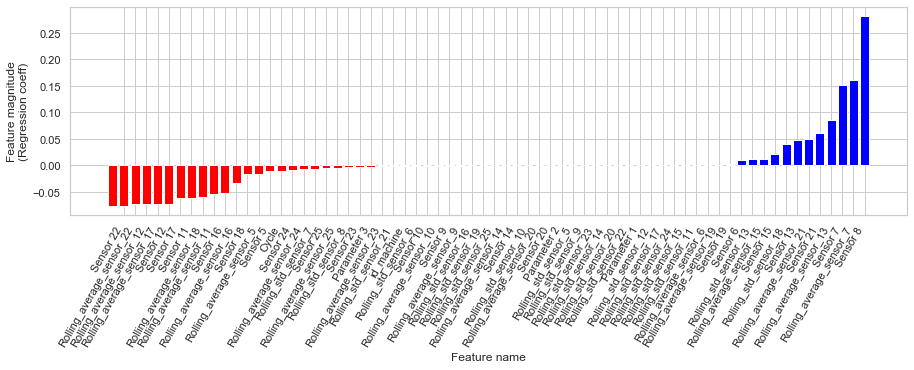

In [38]:
print("\n------ Plotting Feature coefficients --------\n")
feature_names=DF_RUL.iloc[:,0:68].columns
features_coeff_to_plot=1### what % of feature coeffs to plot, max?
plot_feature_coeffs(log_reg,feature_names,features_coeff_to_plot) #On récupère la liste de coefficients précédemment créée et on affecte chaque coeff au paramètre correspondant avant d'afficher le tout sur un graphique

Cela étant fait, on effectue les prédictions sur nos données test et on observe le taux de précision de celui-ci afin de déterminer s'il est viable ou non.

In [39]:
#Making predictions on the testing set
y_pred_lr1 = log_reg.predict(X_test)  

#Comparing actual response values (y_test) with predicted response values (y_pred) in other to see the accuracy of the model 
lr1_accuracy = metrics.accuracy_score(y_test, y_pred_lr1)*100 
print("Logistic Regression model accuracy(in %):", lr1_accuracy) 

Logistic Regression model accuracy(in %): 97.76854416743613


À partir de là, nous pouvons établir un tableau rassemblant les prédictions d'appartenance à l'une de nos 3 classes du départ pour chaque machine (en d'autres termes, le pourcentage de chance qu'une machine se situe dans la classe 0, 1 ou 2).

In [40]:
predictions1 = log_reg.predict_proba(X_test)*100 #On construit une matrice contenant les prédictions sur chaque 
matrix_pred1 = pd.DataFrame(predictions1) 
#On utilise la matrice de prédiction pour construire un tableau rassemblant les id de chaque machine 
#ainsi que la probabilité en pourcentage d'appartenir à une classe lors d'un cycle donné 

matrix_pred1['ID machine'] = DF_RUL_test['id_machine']
matrix_pred1['Cycle'] = DF_RUL_test['Cycle']
matrix_pred1 = matrix_pred1[['ID machine', 'Cycle', 0, 1, 2]] 
matrix_pred1 = matrix_pred1.dropna()
matrix_pred1.head(10)

,ID machine,Cycle,0,1,2
1,1.0,2.0,0.000531,0.585015,99.414454
2,1.0,3.0,0.000657,0.702229,99.297114
3,1.0,4.0,0.000416,0.706692,99.292893
4,1.0,5.0,0.000071,0.692617,99.307312
5,1.0,6.0,0.000526,0.813134,99.186340
6,1.0,7.0,0.000295,0.781100,99.218605
7,1.0,8.0,0.005295,0.884431,99.110274
8,1.0,9.0,0.000273,0.740398,99.259329
9,1.0,10.0,0.000715,0.884068,99.115216
10,1.0,11.0,0.000338,0.818120,99.181541


Nous construisons la matrice de confusion associée à notre modèle. Le principe de la matrice est le suivant : sur la diagonale se trouvent le nombre de prédictions justes, c'est-à-dire le nombre de machines placées dans la bonne classe. Les autres cases correspondent à des prédictions erronées, donc des machines placées dans une classe incorrectes. C'est un très bon outil indicateur de la validité et du niveau de fiabilité de notre modèle.

In [41]:
confusion_matrix1 = confusion_matrix(y_test, y_pred_lr1)
print(confusion_matrix1)

[[   42     1    17]
 [   61     7   204]
 [    7     0 12657]]


In [42]:
#print(classification_report(y_test, y_pred_lr1))

#### 4.1.b-  Réseau de neurones

Dans cette section, nous établissons le réseau de neurones qui effectuera le travail de prédiction à partir des données non équilibrées. L'idée c'est de pouvoir observer le taux de pertes et de précision de notre modèle pour juger de son efficacité.  

In [43]:
#On construit un modèle Keras séquentiel baé sur un empilement liéaire de couches
model = models.Sequential()
model.add(layers.Dense(64, activation='tanh', input_shape=(68,)))
model.add(layers.Dense(64, activation='tanh'))
model.add(layers.Dense(64, activation='tanh'))
model.add(layers.Dense(10, activation='softmax'))
#Dans notre cas nous utilisons 4 couches linéaires pour notre modèle

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [44]:
model1=model.fit(X_train, y_train, epochs=1000, batch_size=512,validation_data=(X_test, y_test)) #Entraînement du modèle

Train on 20531 samples, validate on 12996 samples
Epoch 1/10
20531/20531 [==============================] - 0s 23us/step - loss: 0.6860 - accuracy: 0.8281 - val_loss: 0.4894 - val_accuracy: 0.9745
Epoch 2/10
20531/20531 [==============================] - 0s 11us/step - loss: 0.5416 - accuracy: 0.8490 - val_loss: 0.1946 - val_accuracy: 0.9745
Epoch 3/10
20531/20531 [==============================] - 0s 11us/step - loss: 0.5340 - accuracy: 0.8490 - val_loss: 0.1948 - val_accuracy: 0.9745
Epoch 4/10
20531/20531 [==============================] - 0s 12us/step - loss: 0.5317 - accuracy: 0.8490 - val_loss: 0.3099 - val_accuracy: 0.9745
Epoch 5/10
20531/20531 [==============================] - 0s 12us/step - loss: 0.5316 - accuracy: 0.8490 - val_loss: 0.2700 - val_accuracy: 0.9745
Epoch 6/10
20531/20531 [==============================] - 0s 13us/step - loss: 0.5309 - accuracy: 0.8490 - val_loss: 0.2404 - val_accuracy: 0.9745
Epoch 7/10
20531/20531 [==============================] - 0s 12us/st

Le temps d'entraînement peut prendre un certain temps selon le nombre d'epochs que vous fixer. Pour 1000 epochs par exemple, comptez à peu près 10 à 15 min. 

Par la suite, nous observons les statistiques liées à la précision et aux pertes de notre jeu de d'entraînement et de notre jeu de test.

In [45]:
print(model1.history.keys())
print('val_acc: ',min(model1.history['val_accuracy'])) #Correspond à la précision du jeu de données de validation après entraînement
print('val_loss: ',min(model1.history['val_loss'])) #Correspond à l'erreur sur le jeu de validation après lavoir entraîné avec le modèlll
print('acc: ',min(model1.history['accuracy'])) #Correspond à la précision dujeu d'entraînement
print('loss: ',min(model1.history['loss'])) #Correspond à l'erreur sur le jeu d'entraînement 
print("train/val loss ratio: ", min(model1.history['loss'])/min(model1.history['val_loss']))

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])
val_acc:  0.9744536876678467
val_loss:  0.18902231479982626
acc:  0.82806486
loss:  0.5304282268475792
train/val loss ratio:  2.8061672369704085


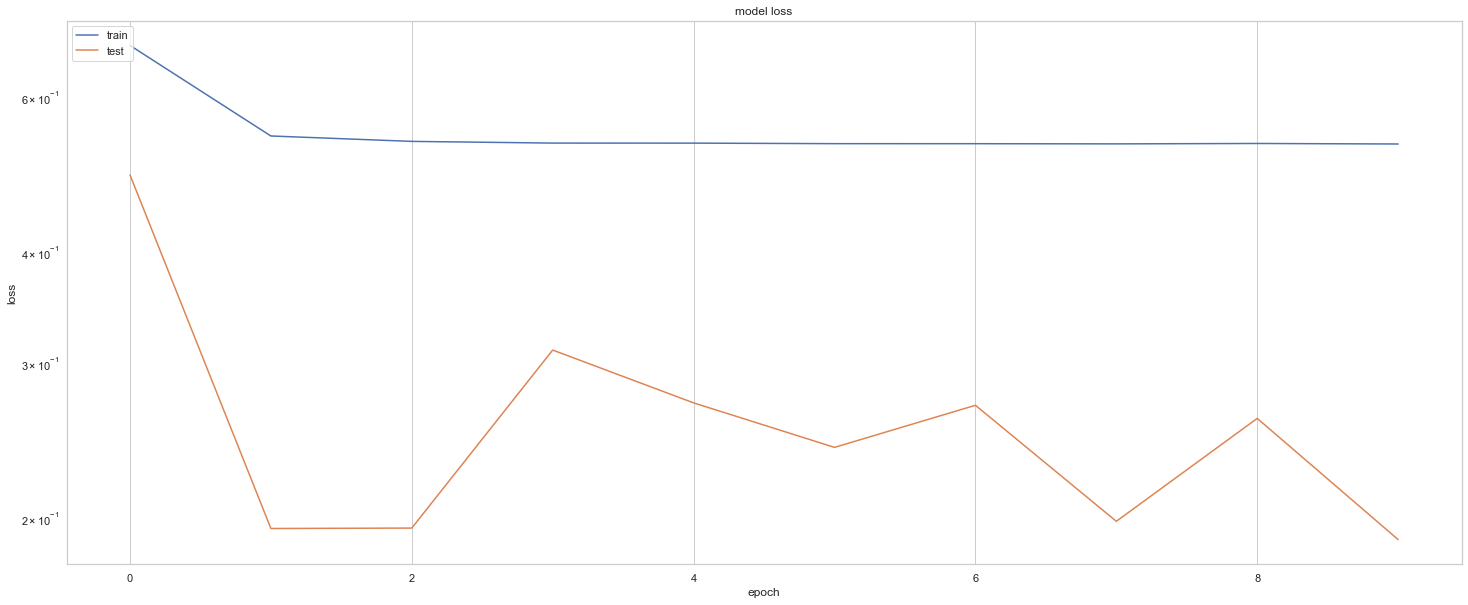

In [46]:
#Affichage des courbes relatives aux pertes du jeu d'entraînement et de notre modèle entraîné

plt.figure(figsize=(25, 10))
plt.semilogy(model1.history['loss'])
plt.semilogy(model1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

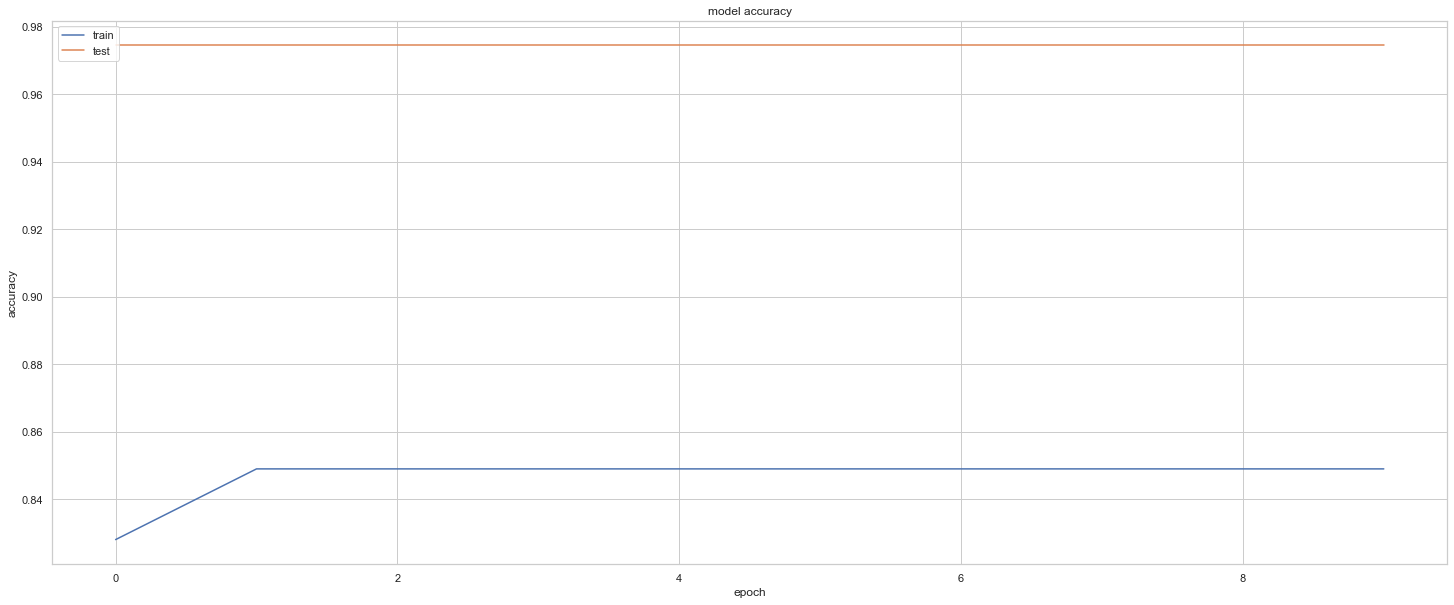

In [47]:
#Affichage des courbes relatives à la précision du jeu d'entraînement et de notre modèle entraîné

plt.figure(figsize=(25, 10))
plt.plot(model1.history['accuracy'])
plt.plot(model1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
scores1 = model.evaluate(X_test, y_test, verbose=1, batch_size=200)
neural_accuracy1 = scores1[1]*100   #On calcule la précision du modèle 
print('Accurracy: {}'.format(neural_accuracy1))

12996/12996 [==============================] - 0s 9us/step
Accurracy: 97.44536876678467


In [49]:
keras_predictions1 = model.predict_proba(X_test)*100
matrix_pred2 = pd.DataFrame(keras_predictions1) 
#On utilise la matrice de prédiction pour construire un tableau rassemblant les id de chaque machine 
#ainsi que la probabilité en pourcentage d'appartenir à une classe lors d'un cycle donné 

matrix_pred2['ID machine'] = DF_RUL_test['id_machine']
matrix_pred2['Cycle'] = DF_RUL_test['Cycle']
matrix_pred2 = matrix_pred2[['ID machine', 'Cycle', 0, 1, 2]] 
matrix_pred2 = matrix_pred2.dropna()
matrix_pred2.head(10)

,ID machine,Cycle,0,1,2
1,1.0,2.0,6.120387,4.782637,89.096985
2,1.0,3.0,6.120387,4.782637,89.096985
3,1.0,4.0,6.120387,4.782637,89.096985
4,1.0,5.0,6.120387,4.782637,89.096985
5,1.0,6.0,6.120387,4.782637,89.096985
6,1.0,7.0,6.120387,4.782637,89.096985
7,1.0,8.0,6.120387,4.782637,89.096985
8,1.0,9.0,6.120387,4.782637,89.096985
9,1.0,10.0,6.120387,4.782637,89.096985
10,1.0,11.0,6.120387,4.782637,89.096985


In [50]:
confusion_matrix7 = metrics.confusion_matrix(y_test, keras_predictions1.argmax(axis=1))
print(confusion_matrix7)

[[    0     0    60]
 [    0     0   272]
 [    0     0 12664]]


#### 4.1.c Modèle Random Forest

Nous allons à présent appliquer le travail fait sur la Régression Logistique en choisissant cette fois-ci la technique du Random Forest afin de voir si les résultats obtenus diffèrent (sont-ils semblables, mieux, moins bien).

In [51]:
clf1 = RandomForestClassifier(n_jobs=-1, random_state=5)

model_RF1=clf1.fit(X_train, y_train)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=5,
            verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=5, verbose=0, warm_start=False)

In [52]:
preds_rfc1=model_RF1.predict(X_test)
rfc1_accuracy = accuracy_score(y_test, preds_rfc1, normalize=True)*100.0
print('Correct Prediction (%): ', rfc1_accuracy)

Correct Prediction (%):  98.31486611265005


In [53]:
# report_rfc1 = classification_report(y_test, preds_rfc1)
# print(report_rfc1)

predictions3 = model_RF1.predict_proba(X_test)
matrix_pred3 = pd.DataFrame(predictions3)*100
#On utilise la matrice de prédiction pour construire un tableau rassemblant les id de chaque machine 
#ainsi que la probabilité en pourcentage d'appartenir à une classe lors d'un cycle donné 

matrix_pred3['ID machine'] = DF_RUL_test['id_machine']
matrix_pred3['Cycle'] = DF_RUL_test['Cycle']
matrix_pred3 = matrix_pred3[['ID machine', 'Cycle', 0, 1, 2]] 
matrix_pred3 = matrix_pred3.dropna()
matrix_pred3.head(10)

,ID machine,Cycle,0,1,2
1,1.0,2.0,0.0,0.0,100.0
2,1.0,3.0,0.0,0.0,100.0
3,1.0,4.0,0.0,0.0,100.0
4,1.0,5.0,0.0,0.0,100.0
5,1.0,6.0,0.0,0.0,100.0
6,1.0,7.0,0.0,0.0,100.0
7,1.0,8.0,0.0,0.0,100.0
8,1.0,9.0,0.0,0.0,100.0
9,1.0,10.0,0.0,0.0,100.0
10,1.0,11.0,0.0,0.0,100.0



------ Plotting Feature coefficients --------



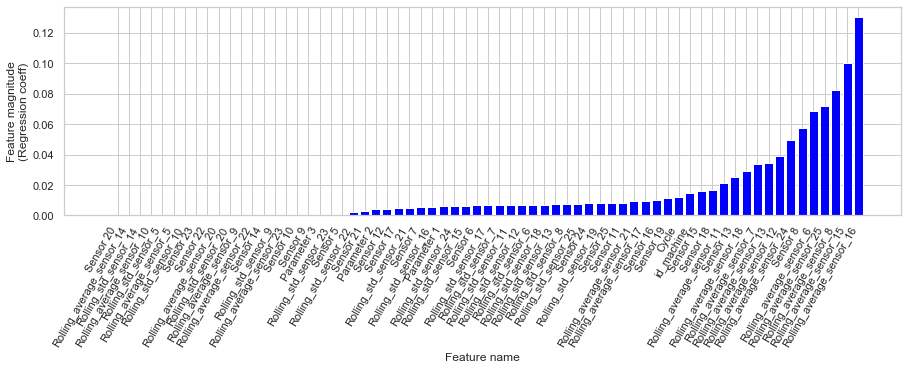

In [54]:
print("\n------ Plotting Feature coefficients --------\n")
feature_names=DF_RUL.iloc[:,0:68].columns
features_coeff_to_plot=1### what % of feature coeffs to plot, max?
plot_feature_coeffs_spec(model_RF1,feature_names,features_coeff_to_plot) #Affichage des coefficients uaffectés par Random Forest

In [55]:
confusion_matrix3 = confusion_matrix(y_test, preds_rfc1)
print(confusion_matrix3)

[[   35    24     1]
 [   13   146   113]
 [    0    68 12596]]


#### 4.1.d KNN Classification

Même travail avec la méthode du K-Nearest Neighbors (les K voisins plus proches).

In [56]:
# Make predictions on validation dataset
knn1 = KNeighborsClassifier(n_neighbors=100)
knn1.fit(X_train, y_train)
knn_predictions1 = knn1.predict(X_test)
knn1_accuracy = accuracy_score(y_test, knn_predictions1)*100
print(knn1_accuracy)
#print(classification_report(y_test, predictions1))

97.668513388735


In [57]:
predictions4 = knn1.predict_proba(X_test)
matrix_pred4 = pd.DataFrame(predictions4)*100
#On utilise la matrice de prédiction pour construire un tableau rassemblant les id de chaque machine 
#ainsi que la probabilité en pourcentage d'appartenir à une classe lors d'un cycle donné 

matrix_pred4['ID machine'] = DF_RUL_test['id_machine']
matrix_pred4['Cycle'] = DF_RUL_test['Cycle']
matrix_pred4 = matrix_pred4[['ID machine', 'Cycle', 0, 1, 2]] 
matrix_pred4 = matrix_pred4.dropna()
matrix_pred4.head(10)

,ID machine,Cycle,0,1,2
1,1.0,2.0,0.0,0.0,100.0
2,1.0,3.0,0.0,0.0,100.0
3,1.0,4.0,0.0,0.0,100.0
4,1.0,5.0,0.0,0.0,100.0
5,1.0,6.0,0.0,0.0,100.0
6,1.0,7.0,0.0,0.0,100.0
7,1.0,8.0,0.0,0.0,100.0
8,1.0,9.0,0.0,0.0,100.0
9,1.0,10.0,0.0,0.0,100.0
10,1.0,11.0,0.0,0.0,100.0


In [58]:
confusion_matrix5 = confusion_matrix(y_test, knn_predictions1)
print(confusion_matrix5)

[[   31    12    17]
 [   48    25   199]
 [    0    27 12637]]


Globalement, nos modèles affichent de très bons résultats. Des résultats beaucoup trop justes cela dit. Pourquoi ? Comme nous nous l'avons mentionné précédemment, le jeu de données non équilibré présente une prépondérance de la classe 2 (85 % du jeu de données). Ce qui signifie qu'en prédisant que les machines se trouvent en classe 2, nos modèles ont 85% de chances d'avoir la bonne réponse. Ces résultats ne sont pas très explicites mais cela n'empêche pas au modèle d'être fiable et précis. 

### 4.2- Données équilibrées
Pour palier à ce désequilibre des classes dans le jeu de données, nous allons utiliser une librairie appelée SMOTE. Cette librairie python va créer un ensemble de données synthetiques dans les classes minoritaires.

In [59]:
#On répartit les données dans nos 3 classes de façon à obtenir des proportions égales dans chaque classe

os = SMOTE(random_state=0) #Outils permettant de parser les données 

columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train) #On stock les données parsées dans deux nouvelles variables d'entraînements
os_data_X = pd.DataFrame(data=os_data_X,columns=columns ) #On crée un nouveau dataframe à partir des nouvelles variables oversamplées
os_data_y= pd.DataFrame(data=os_data_y,columns=['Target'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of target 0 oversampled data",len(os_data_y[os_data_y['Target']==0]))
print("Number of Target 1",len(os_data_y[os_data_y['Target']==1]))
print("Number of Target 2",len(os_data_y[os_data_y['Target']==2]))
print("Proportion of taregt 0 in oversampled data is ",len(os_data_y[os_data_y['Target']==0])/len(os_data_X)*100,"%")
print("Proportion of target 1 in oversampled data is ",len(os_data_y[os_data_y['Target']==1])/len(os_data_X)*100,"%")
print("Proportion of target 2 in oversampled data is ",len(os_data_y[os_data_y['Target']==2])/len(os_data_X)*100,"%")

length of oversampled data is  52293
Number of target 0 oversampled data 17431
Number of Target 1 17431
Number of Target 2 17431
Proportion of taregt 0 in oversampled data is  33.33333333333333 %
Proportion of target 1 in oversampled data is  33.33333333333333 %
Proportion of target 2 in oversampled data is  33.33333333333333 %


#### 4.2.a Régression logistique multiclasses 
Maintenant, effectuons le même travail que précédemment mais, cette fois, avec nos données d'entraînement équilibrées (oversampled). Les commentaires pour chacune des opérations à venir dans cette partie sont strictement les mêmes que ceux utilisés dans les opérations sans oversampling.   

In [60]:
# INIT LOGISTIC REGRESSION CLASSIFIER
print("Training a Logistic Regression Model...")
log_reg2 = linear_model.LogisticRegression() 
log_reg2.fit(os_data_X,os_data_y)

Training a Logistic Regression Model...


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [61]:
# Assign the coefficients to a list coef
coef = log_reg2.coef_

In [62]:
# making predictions on the testing set 
y_pred_lr2 = log_reg2.predict(X_test) 
lr2_accuracy = metrics.accuracy_score(y_pred_lr2, y_test)*100
print("Logistic Regression model accuracy(in %):", lr2_accuracy) 

Logistic Regression model accuracy(in %): 97.56848261003385


In [63]:
predictions5 = log_reg2.predict_proba(X_test)
matrix_pred5 = pd.DataFrame(predictions5)*100
#On utilise la matrice de prédiction pour construire un tableau rassemblant les id de chaque machine 
#ainsi que la probabilité en pourcentage d'appartenir à une classe lors d'un cycle donné 

matrix_pred5['ID machine'] = DF_RUL_test['id_machine']
matrix_pred5['Cycle'] = DF_RUL_test['Cycle']
matrix_pred5 = matrix_pred5[['ID machine', 'Cycle', 0, 1, 2]] 
matrix_pred5 = matrix_pred5.dropna()
matrix_pred5.head(10)

,ID machine,Cycle,0,1,2
1,1.0,2.0,0.000122,10.885878,89.114000
2,1.0,3.0,0.000126,11.181594,88.818280
3,1.0,4.0,0.000088,11.278915,88.720997
4,1.0,5.0,0.000018,11.400099,88.599883
5,1.0,6.0,0.000078,11.462531,88.537391
6,1.0,7.0,0.000060,11.553097,88.446844
7,1.0,8.0,0.000613,11.513969,88.485417
8,1.0,9.0,0.000056,11.604948,88.394996
9,1.0,10.0,0.000149,11.741043,88.258808
10,1.0,11.0,0.000077,11.785821,88.214101


In [64]:
confusion_matrix2 = confusion_matrix(y_test, y_pred_lr2)
print(confusion_matrix2)

[[   41    18     1]
 [   44   168    60]
 [    5   188 12471]]


In [65]:
#print(classification_report(y_test, y_pred_lr2))


------ Plotting Feature coefficients --------



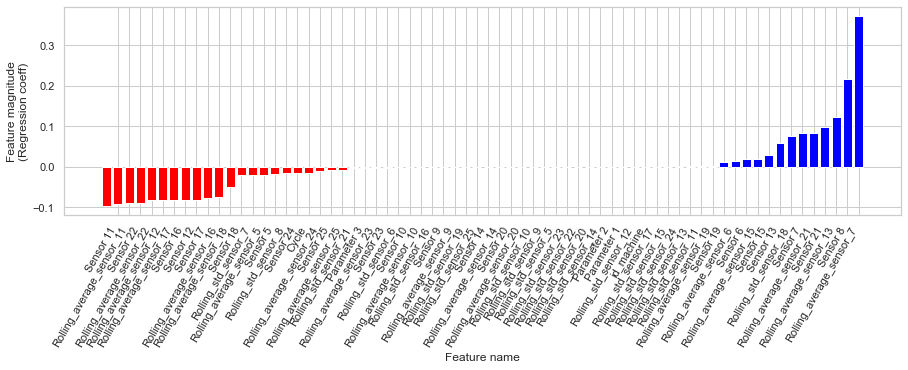

In [66]:
print("\n------ Plotting Feature coefficients --------\n")

feature_names=DF_RUL.iloc[:,0:68].columns
features_coeff_to_plot=1### what % of feature coeffs to plot, max?
plot_feature_coeffs(log_reg2,feature_names,features_coeff_to_plot)


#### 4.2.b Modèle Keras

In [67]:
#Changement par rapport au précédent réseau de neurones : nous utilisons, en tant qu'optimizer, adam en tant izer qui une fusion
opt=optimizers.adam(lr=0.0001,decay = 0.001)

model_bis = models.Sequential()
model_bis.add(layers.Dense(32, activation='relu', input_shape=(68,)))
model_bis.add(layers.Dense(3, activation='softmax'))

model_bis.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [68]:
model2=model_bis.fit(os_data_X, os_data_y, epochs=1000, validation_data = (X_test,y_test))

Train on 52293 samples, validate on 12996 samples
Epoch 1/1000
52293/52293 [==============================] - 3s 59us/step - loss: 96.8976 - accuracy: 0.4998 - val_loss: 1.0909 - val_accuracy: 0.8460
Epoch 2/1000
52293/52293 [==============================] - 3s 50us/step - loss: 3.4496 - accuracy: 0.5209 - val_loss: 1.3756 - val_accuracy: 0.8046
Epoch 3/1000
52293/52293 [==============================] - 3s 58us/step - loss: 3.0870 - accuracy: 0.5173 - val_loss: 0.7024 - val_accuracy: 0.8810
Epoch 4/1000
52293/52293 [==============================] - 2s 40us/step - loss: 2.9191 - accuracy: 0.5115 - val_loss: 0.9933 - val_accuracy: 0.8396
Epoch 5/1000
52293/52293 [==============================] - 2s 37us/step - loss: 2.8314 - accuracy: 0.5083 - val_loss: 1.8661 - val_accuracy: 0.7118
Epoch 6/1000
52293/52293 [==============================] - 2s 45us/step - loss: 2.7579 - accuracy: 0.5050 - val_loss: 1.4260 - val_accuracy: 0.7572
Epoch 7/1000
52293/52293 [=============================

52293/52293 [==============================] - 3s 48us/step - loss: 2.1960 - accuracy: 0.4971 - val_loss: 0.8892 - val_accuracy: 0.8290
Epoch 110/1000
52293/52293 [==============================] - 2s 46us/step - loss: 2.1954 - accuracy: 0.4981 - val_loss: 1.0424 - val_accuracy: 0.8023
Epoch 111/1000
52293/52293 [==============================] - 2s 46us/step - loss: 2.1940 - accuracy: 0.4983 - val_loss: 1.0784 - val_accuracy: 0.7967
Epoch 112/1000
52293/52293 [==============================] - 2s 47us/step - loss: 2.1925 - accuracy: 0.4961 - val_loss: 0.8785 - val_accuracy: 0.8302
Epoch 113/1000
52293/52293 [==============================] - 2s 47us/step - loss: 2.1909 - accuracy: 0.4975 - val_loss: 1.1807 - val_accuracy: 0.7795
Epoch 114/1000
52293/52293 [==============================] - 4s 67us/step - loss: 2.1890 - accuracy: 0.4965 - val_loss: 1.0273 - val_accuracy: 0.8057
Epoch 115/1000
52293/52293 [==============================] - 3s 52us/step - loss: 2.1891 - accuracy: 0.4979 

52293/52293 [==============================] - 2s 39us/step - loss: 2.0946 - accuracy: 0.4973 - val_loss: 1.0541 - val_accuracy: 0.7960
Epoch 218/1000
52293/52293 [==============================] - 2s 39us/step - loss: 2.0938 - accuracy: 0.4972 - val_loss: 1.0940 - val_accuracy: 0.7902
Epoch 219/1000
52293/52293 [==============================] - 2s 45us/step - loss: 2.0942 - accuracy: 0.4972 - val_loss: 0.9769 - val_accuracy: 0.8119
Epoch 220/1000
52293/52293 [==============================] - 2s 47us/step - loss: 2.0936 - accuracy: 0.4974 - val_loss: 1.0748 - val_accuracy: 0.7923
Epoch 221/1000
52293/52293 [==============================] - 2s 42us/step - loss: 2.0929 - accuracy: 0.4977 - val_loss: 0.8602 - val_accuracy: 0.8311
Epoch 222/1000
52293/52293 [==============================] - 2s 38us/step - loss: 2.0918 - accuracy: 0.4979 - val_loss: 0.9655 - val_accuracy: 0.8129
Epoch 223/1000
52293/52293 [==============================] - 2s 43us/step - loss: 2.0902 - accuracy: 0.4977 

52293/52293 [==============================] - 2s 43us/step - loss: 2.0380 - accuracy: 0.4967 - val_loss: 0.9822 - val_accuracy: 0.8082
Epoch 326/1000
52293/52293 [==============================] - 2s 42us/step - loss: 2.0371 - accuracy: 0.4975 - val_loss: 0.9218 - val_accuracy: 0.8189
Epoch 327/1000
52293/52293 [==============================] - 2s 43us/step - loss: 2.0378 - accuracy: 0.4969 - val_loss: 0.9052 - val_accuracy: 0.8224
Epoch 328/1000
52293/52293 [==============================] - 3s 55us/step - loss: 2.0372 - accuracy: 0.4976 - val_loss: 0.9112 - val_accuracy: 0.8206
Epoch 329/1000
52293/52293 [==============================] - 2s 46us/step - loss: 2.0361 - accuracy: 0.4973 - val_loss: 0.9486 - val_accuracy: 0.8140
Epoch 330/1000
52293/52293 [==============================] - 2s 43us/step - loss: 2.0361 - accuracy: 0.4977 - val_loss: 0.9203 - val_accuracy: 0.8199
Epoch 331/1000
52293/52293 [==============================] - 2s 44us/step - loss: 2.0361 - accuracy: 0.4972 

52293/52293 [==============================] - 2s 39us/step - loss: 1.9995 - accuracy: 0.4972 - val_loss: 0.9618 - val_accuracy: 0.8110
Epoch 434/1000
52293/52293 [==============================] - 2s 42us/step - loss: 1.9995 - accuracy: 0.4965 - val_loss: 0.8942 - val_accuracy: 0.8229
Epoch 435/1000
52293/52293 [==============================] - 3s 58us/step - loss: 1.9986 - accuracy: 0.4977 - val_loss: 0.9479 - val_accuracy: 0.8133
Epoch 436/1000
52293/52293 [==============================] - 2s 42us/step - loss: 1.9985 - accuracy: 0.4977 - val_loss: 0.9265 - val_accuracy: 0.8171
Epoch 437/1000
52293/52293 [==============================] - 2s 42us/step - loss: 1.9986 - accuracy: 0.4969 - val_loss: 0.9497 - val_accuracy: 0.8137
Epoch 438/1000
52293/52293 [==============================] - 2s 40us/step - loss: 1.9980 - accuracy: 0.4975 - val_loss: 0.8413 - val_accuracy: 0.8320
Epoch 439/1000
52293/52293 [==============================] - 2s 40us/step - loss: 1.9975 - accuracy: 0.4973 

52293/52293 [==============================] - 3s 51us/step - loss: 1.9703 - accuracy: 0.4966 - val_loss: 0.9299 - val_accuracy: 0.8160
Epoch 542/1000
52293/52293 [==============================] - 3s 48us/step - loss: 1.9698 - accuracy: 0.4973 - val_loss: 0.8916 - val_accuracy: 0.8235
Epoch 543/1000
52293/52293 [==============================] - 3s 61us/step - loss: 1.9692 - accuracy: 0.4980 - val_loss: 0.9153 - val_accuracy: 0.8183
Epoch 544/1000
52293/52293 [==============================] - 3s 53us/step - loss: 1.9690 - accuracy: 0.4975 - val_loss: 0.8878 - val_accuracy: 0.8233
Epoch 545/1000
52293/52293 [==============================] - 3s 49us/step - loss: 1.9693 - accuracy: 0.4971 - val_loss: 0.9309 - val_accuracy: 0.8157
Epoch 546/1000
52293/52293 [==============================] - 3s 51us/step - loss: 1.9685 - accuracy: 0.4973 - val_loss: 0.9375 - val_accuracy: 0.8148
Epoch 547/1000
52293/52293 [==============================] - 3s 49us/step - loss: 1.9685 - accuracy: 0.4972 

52293/52293 [==============================] - 3s 62us/step - loss: 1.9463 - accuracy: 0.4980 - val_loss: 0.9158 - val_accuracy: 0.8175
Epoch 650/1000
52293/52293 [==============================] - 2s 44us/step - loss: 1.9465 - accuracy: 0.4976 - val_loss: 0.8994 - val_accuracy: 0.8208
Epoch 651/1000
52293/52293 [==============================] - 2s 38us/step - loss: 1.9461 - accuracy: 0.4978 - val_loss: 0.9156 - val_accuracy: 0.8174
Epoch 652/1000
52293/52293 [==============================] - 2s 38us/step - loss: 1.9458 - accuracy: 0.4968 - val_loss: 0.9368 - val_accuracy: 0.8144
Epoch 653/1000
52293/52293 [==============================] - 2s 39us/step - loss: 1.9456 - accuracy: 0.4973 - val_loss: 0.8896 - val_accuracy: 0.8226
Epoch 654/1000
52293/52293 [==============================] - 2s 37us/step - loss: 1.9452 - accuracy: 0.4973 - val_loss: 0.9283 - val_accuracy: 0.8154
Epoch 655/1000
52293/52293 [==============================] - 2s 41us/step - loss: 1.9452 - accuracy: 0.4977 

52293/52293 [==============================] - 16s 312us/step - loss: 1.9267 - accuracy: 0.4968 - val_loss: 0.8832 - val_accuracy: 0.8236
Epoch 758/1000
52293/52293 [==============================] - 11s 211us/step - loss: 1.9264 - accuracy: 0.4972 - val_loss: 0.8596 - val_accuracy: 0.8273
Epoch 759/1000
52293/52293 [==============================] - 6s 115us/step - loss: 1.9264 - accuracy: 0.4974 - val_loss: 0.9219 - val_accuracy: 0.8156
Epoch 760/1000
52293/52293 [==============================] - 4s 71us/step - loss: 1.9258 - accuracy: 0.4972 - val_loss: 0.8657 - val_accuracy: 0.8256
Epoch 761/1000
52293/52293 [==============================] - 4s 67us/step - loss: 1.9259 - accuracy: 0.4972 - val_loss: 0.8378 - val_accuracy: 0.8308
Epoch 762/1000
52293/52293 [==============================] - 4s 70us/step - loss: 1.9260 - accuracy: 0.4968 - val_loss: 0.8918 - val_accuracy: 0.8218
Epoch 763/1000
52293/52293 [==============================] - 3s 59us/step - loss: 1.9252 - accuracy: 0.

52293/52293 [==============================] - 3s 62us/step - loss: 1.9101 - accuracy: 0.4972 - val_loss: 0.8647 - val_accuracy: 0.8263
Epoch 866/1000
52293/52293 [==============================] - 3s 62us/step - loss: 1.9098 - accuracy: 0.4976 - val_loss: 0.9071 - val_accuracy: 0.8177
Epoch 867/1000
52293/52293 [==============================] - 3s 60us/step - loss: 1.9097 - accuracy: 0.4973 - val_loss: 0.9212 - val_accuracy: 0.8158
Epoch 868/1000
52293/52293 [==============================] - 3s 60us/step - loss: 1.9096 - accuracy: 0.4985 - val_loss: 0.8718 - val_accuracy: 0.8249
Epoch 869/1000
52293/52293 [==============================] - 4s 70us/step - loss: 1.9087 - accuracy: 0.4971 - val_loss: 0.8377 - val_accuracy: 0.8299
Epoch 870/1000
52293/52293 [==============================] - 3s 65us/step - loss: 1.9091 - accuracy: 0.4976 - val_loss: 0.8989 - val_accuracy: 0.8194
Epoch 871/1000
52293/52293 [==============================] - 4s 73us/step - loss: 1.9090 - accuracy: 0.4976 

52293/52293 [==============================] - 3s 60us/step - loss: 1.8950 - accuracy: 0.4970 - val_loss: 0.8165 - val_accuracy: 0.8336
Epoch 974/1000
52293/52293 [==============================] - 3s 60us/step - loss: 1.8954 - accuracy: 0.4980 - val_loss: 0.8651 - val_accuracy: 0.8251
Epoch 975/1000
52293/52293 [==============================] - 3s 59us/step - loss: 1.8952 - accuracy: 0.4976 - val_loss: 0.9250 - val_accuracy: 0.8146
Epoch 976/1000
52293/52293 [==============================] - 3s 60us/step - loss: 1.8952 - accuracy: 0.4977 - val_loss: 0.9062 - val_accuracy: 0.8173
Epoch 977/1000
52293/52293 [==============================] - 3s 59us/step - loss: 1.8949 - accuracy: 0.4967 - val_loss: 0.9036 - val_accuracy: 0.8179
Epoch 978/1000
52293/52293 [==============================] - 3s 59us/step - loss: 1.8947 - accuracy: 0.4973 - val_loss: 0.8675 - val_accuracy: 0.8254
Epoch 979/1000
52293/52293 [==============================] - 3s 60us/step - loss: 1.8945 - accuracy: 0.4974 

In [69]:
print(model2.history.keys())
print('val_acc: ',min(model2.history['val_accuracy']))
print('val_loss: ',min(model2.history['val_loss']))
print('acc: ',min(model2.history['accuracy']))
print('loss: ',min(model2.history['loss']))
print("train/val loss ratio: ", min(model2.history['loss'])/min(model2.history['val_loss']))

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])
val_acc:  0.711757481098175
val_loss:  0.6754720040034481
acc:  0.49561128
loss:  1.8918679957254831
train/val loss ratio:  2.8008088929113124


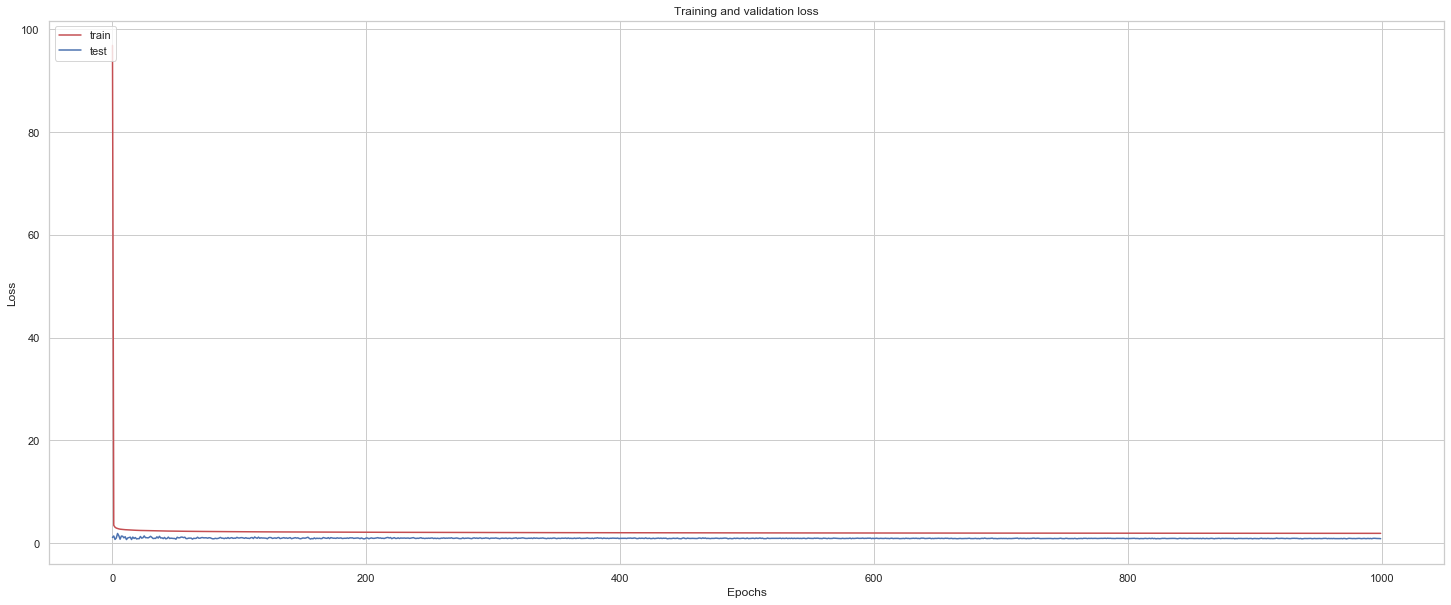

In [70]:
plt.figure(figsize=(25, 10))
plt.plot(model2.history['loss'], 'r', label='Training_loss')
plt.plot(model2.history['val_loss'], 'b', label='Validation_loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<Figure size 432x288 with 0 Axes>

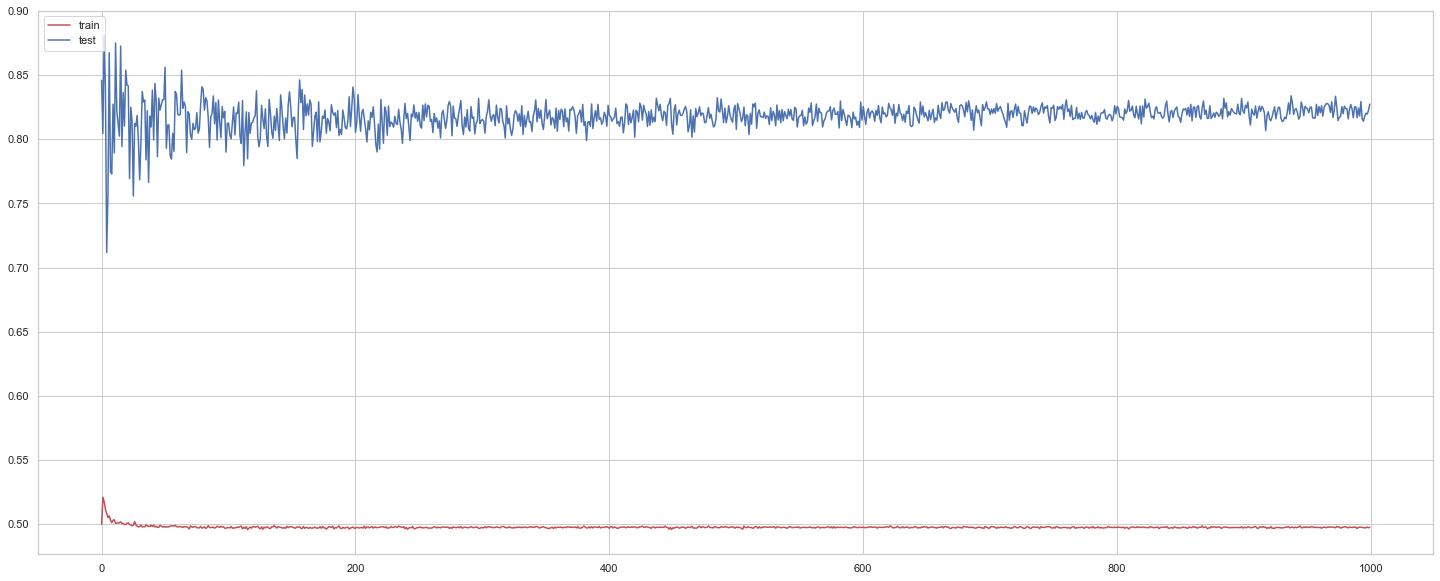

In [71]:
plt.clf()
plt.figure(figsize=(25, 10))
plt.plot(model2.history['accuracy'], 'r', label='Training_accuracy')
plt.plot(model2.history['val_accuracy'], 'b', label='Validaion_accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [72]:
result = model_bis.evaluate(X_test, y_test)

12996/12996 [==============================] - 0s 35us/step


In [73]:
result

[0.8547758834557401, 0.8274853825569153]

In [74]:
scores2 = model_bis.evaluate(X_test, y_test, verbose=1, batch_size=200)
neural_accuracy2 = scores2[1]*100
print('Accurracy: {}'.format(neural_accuracy2))

12996/12996 [==============================] - 0s 6us/step
Accurracy: 82.74853825569153


In [75]:
predictions6 = model_bis.predict_proba(X_test)
matrix_pred6 = pd.DataFrame(predictions6)*100
#On utilise la matrice de prédiction pour construire un tableau rassemblant les id de chaque machine 
#ainsi que la probabilité en pourcentage d'appartenir à une classe lors d'un cycle donné 

matrix_pred6['ID machine'] = DF_RUL_test['id_machine']
matrix_pred6['Cycle'] = DF_RUL_test['Cycle']
matrix_pred6 = matrix_pred6[['ID machine', 'Cycle', 0, 1, 2]] 
matrix_pred6 = matrix_pred6.dropna()
matrix_pred6.head(10)

,ID machine,Cycle,0,1,2
1,1.0,2.0,0.008241,0.011236,99.980530
2,1.0,3.0,0.000355,0.012423,99.987221
3,1.0,4.0,0.000273,0.005576,99.994148
4,1.0,5.0,0.002574,0.005148,99.992279
5,1.0,6.0,0.000091,0.004057,99.995850
6,1.0,7.0,0.000512,0.006529,99.992958
7,1.0,8.0,0.000031,0.016526,99.983444
8,1.0,9.0,0.001420,0.004606,99.993965
9,1.0,10.0,0.001051,0.009320,99.989632
10,1.0,11.0,0.001934,0.003631,99.994431


In [77]:
confusion_matrix8 = metrics.confusion_matrix(y_test, predictions6.argmax(axis=1))
print(confusion_matrix8)

[[   16    32    12]
 [   78   117    77]
 [ 1345   698 10621]]


#### 4.2.c Modèle Random Forest 

In [78]:
clf2 = RandomForestClassifier(n_jobs=-1, random_state=5)

model_RF2=clf2.fit(os_data_X, os_data_y)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=5,
            verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=5, verbose=0, warm_start=False)

In [79]:
preds2=model_RF2.predict(X_test)
rfc2_accuracy = accuracy_score(y_test, preds2, normalize=True)*100.0
print('Correct Prediction (%): ', rfc2_accuracy)

Correct Prediction (%):  97.85318559556787


In [80]:
# report_rfc2 = classification_report(y_test, model_RF2.predict(X_test))
# print(report_rfc2)

predictions7 = model_RF2.predict_proba(X_test)
matrix_pred7 = pd.DataFrame(predictions7)*100
#On utilise la matrice de prédiction pour construire un tableau rassemblant les id de chaque machine 
#ainsi que la probabilité en pourcentage d'appartenir à une classe lors d'un cycle donné 

matrix_pred7['ID machine'] = DF_RUL_test['id_machine']
matrix_pred7['Cycle'] = DF_RUL_test['Cycle']
matrix_pred7 = matrix_pred7[['ID machine', 'Cycle', 0, 1, 2]] 
matrix_pred7 = matrix_pred7.dropna()
matrix_pred7.head(10)

,ID machine,Cycle,0,1,2
1,1.0,2.0,0.0,0.0,100.0
2,1.0,3.0,0.0,0.0,100.0
3,1.0,4.0,0.0,0.0,100.0
4,1.0,5.0,0.0,0.0,100.0
5,1.0,6.0,0.0,0.0,100.0
6,1.0,7.0,0.0,0.0,100.0
7,1.0,8.0,0.0,0.0,100.0
8,1.0,9.0,0.0,0.0,100.0
9,1.0,10.0,0.0,0.0,100.0
10,1.0,11.0,0.0,0.0,100.0



------ Plotting Feature coefficients --------



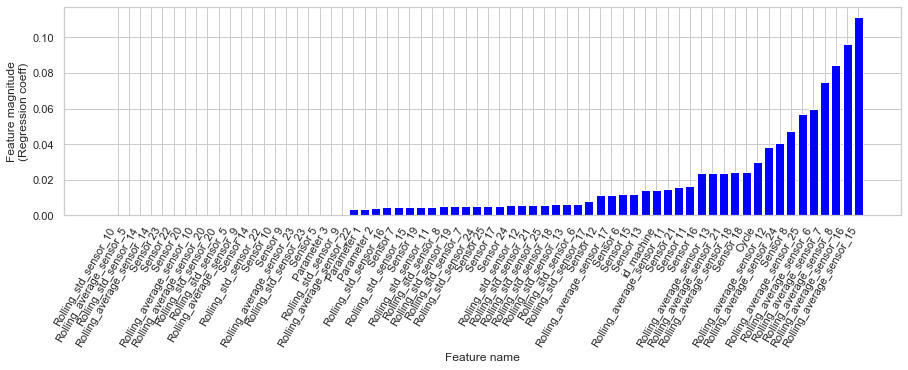

In [81]:
print("\n------ Plotting Feature coefficients --------\n")
feature_names=DF_RUL.iloc[:,0:68].columns
features_coeff_to_plot=1### what % of feature coeffs to plot, max?
plot_feature_coeffs_spec(model_RF2,feature_names,features_coeff_to_plot)

In [82]:
confusion_matrix4 = confusion_matrix(y_test, preds2)
print(confusion_matrix4)

[[   36    24     0]
 [   17   181    74]
 [    1   163 12500]]


#### 4.2.d KNN Classification

Même travail avec la méthode du K-Nearest Neighbors (les K voisins plus proches).

In [83]:
# Make predictions on validation dataset
knn2 = KNeighborsClassifier(n_neighbors=100)
knn2.fit(os_data_X, os_data_y)
predictions2 = knn2.predict(X_test)
knn2_accuracy = accuracy_score(y_test, predictions2)*100
print(knn2_accuracy)
#print(confusion_matrix(y_test, predictions))
#print(classification_report(y_test, predictions2))

92.48230224684518


In [84]:
predictions8 = knn2.predict_proba(X_test)
matrix_pred8 = pd.DataFrame(predictions8)*100
#On utilise la matrice de prédiction pour construire un tableau rassemblant les id de chaque machine 
#ainsi que la probabilité en pourcentage d'appartenir à une classe lors d'un cycle donné 

matrix_pred8['ID machine'] = DF_RUL_test['id_machine']
matrix_pred8['Cycle'] = DF_RUL_test['Cycle']
matrix_pred8 = matrix_pred8[['ID machine', 'Cycle', 0, 1, 2]] 
matrix_pred8 = matrix_pred8.dropna()
matrix_pred8.head(10)

,ID machine,Cycle,0,1,2
1,1.0,2.0,0.0,0.0,100.0
2,1.0,3.0,0.0,0.0,100.0
3,1.0,4.0,0.0,0.0,100.0
4,1.0,5.0,0.0,0.0,100.0
5,1.0,6.0,0.0,0.0,100.0
6,1.0,7.0,0.0,0.0,100.0
7,1.0,8.0,0.0,0.0,100.0
8,1.0,9.0,0.0,0.0,100.0
9,1.0,10.0,0.0,0.0,100.0
10,1.0,11.0,0.0,0.0,100.0


In [85]:
confusion_matrix6 = confusion_matrix(y_test, predictions2)
print(confusion_matrix6)

[[   32    28     0]
 [   66   162    44]
 [   69   770 11825]]


Les résultats obtenus sont proches de ceux escomptés. En effet, le niveau de précision de ce modèle est satisfaisant et les courbes obtenues ainsi que les matrices de confusions l'attestent.

Faut-il donc équilibrer nos données au risque de perdre en précision ?
Oui car on obtient un modèle plus représentatif de la réalité. Sans équilibrage, on obtiendrait un modèle idéale mais qui nécessiterait pour le coup de fixer une classe plus prépondérante que les autres.

### 5- COMPARATEUR D'ALGORITHMES ###

Afin de compléter nos tests sur les différentes techniques de prédiction exploitées, nous allons établir un algorithme de comparaison entre ces techniques dans le but d'avoir une vision plus globale sur l'efficacité de chacune.

Nous l'observerons au travers d'une estimation des taux de précision ainsi que par la construction de matrices de confusion. Pour rappel, le but de la manoeuvre est de pouvoir mener une étude comparative afin de déterminer laquelle de ces techniques est la plus fiable dans le cadre de la maintenance prédictive.

In [86]:
data = np.array([['','accuracy pre oversampling','accuracy post oversampling'],
                ['Logistic Regression',lr1_accuracy, lr2_accuracy],
                ['Random Forest Classification',rfc1_accuracy,rfc2_accuracy],
                ['K-Nearest Neighbours',knn1_accuracy,knn2_accuracy],
                ['Keras Neural Network', neural_accuracy1,neural_accuracy2]])
                
resultats_fin = pd.DataFrame(data=data[1:,1:],
                  index=data[1:,0],
                  columns=data[0,1:])
resultats_fin

,accuracy pre oversampling,accuracy post oversampling
Logistic Regression,97.76854416743613,97.56848261003385
Random Forest Classification,98.31486611265005,97.85318559556787
K-Nearest Neighbours,97.668513388735,92.48230224684518
Keras Neural Network,97.44536876678467,82.74853825569153


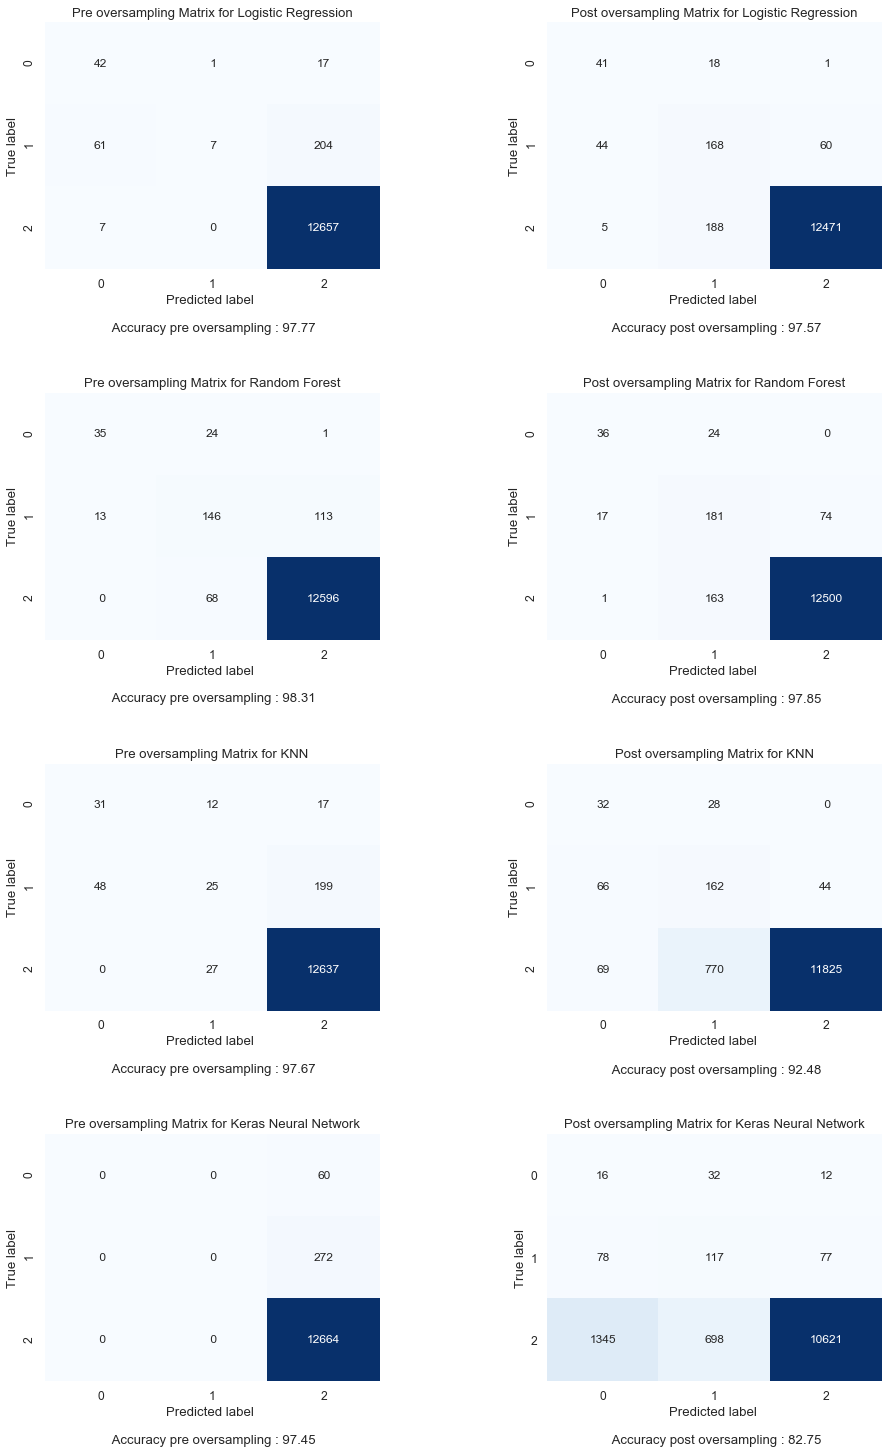

In [88]:
f,ax=plt.subplots(4,2,figsize=(15,25))
sns.set(font_scale=1.1)

################ Logistic Regression ##################
sns.heatmap(confusion_matrix1, cmap ="Blues",ax=ax[0,0],annot=True,annot_kws={"size": 12},cbar=False,fmt='2.0f')
ax[0,0].set(ylabel='True label',xlabel='Predicted label \n\n Accuracy pre oversampling : {:.2f}'.format(lr1_accuracy))
ax[0,0].set_title('Pre oversampling Matrix for Logistic Regression')

sns.heatmap(confusion_matrix2,cmap ="Blues",ax=ax[0,1],annot=True,annot_kws={"size": 12},cbar=False,fmt='2.0f')
ax[0,1].set(ylabel='True label',xlabel='Predicted label \n\n Accuracy post oversampling : {:.2f}'.format(lr2_accuracy))
ax[0,1].set_title('Post oversampling Matrix for Logistic Regression')

################### Random Forest #####################
sns.heatmap(confusion_matrix3,cmap ="Blues",ax=ax[1,0],annot=True,annot_kws={"size": 12},cbar=False,fmt='2.0f')
ax[1,0].set(ylabel='True label',xlabel='Predicted label \n\n Accuracy pre oversampling : {:.2f}'.format(rfc1_accuracy))
ax[1,0].set_title('Pre oversampling Matrix for Random Forest')

sns.heatmap(confusion_matrix4,cmap ="Blues",ax=ax[1,1],annot=True,annot_kws={"size": 12},cbar=False,fmt='2.0f')
ax[1,1].set(ylabel='True label',xlabel='Predicted label \n\n Accuracy post oversampling : {:.2f}'.format(rfc2_accuracy))
ax[1,1].set_title('Post oversampling Matrix for Random Forest')

################ K-Nearest Neighbours ##################
sns.heatmap(confusion_matrix5,cmap ="Blues",ax=ax[2,0],annot=True,annot_kws={"size": 12},cbar=False,fmt='2.0f')
ax[2,0].set(ylabel='True label',xlabel='Predicted label \n\n Accuracy pre oversampling : {:.2f}'.format(knn1_accuracy))
ax[2,0].set_title('Pre oversampling Matrix for KNN')

sns.heatmap(confusion_matrix6,cmap ="Blues",ax=ax[2,1],annot=True,annot_kws={"size": 12},cbar=False,fmt='2.0f')
ax[2,1].set(ylabel='True label',xlabel='Predicted label \n\n Accuracy post oversampling : {:.2f}'.format(knn2_accuracy))
ax[2,1].set_title('Post oversampling Matrix for KNN')

################ Keras Neural Network ##################
sns.heatmap(confusion_matrix7,cmap ="Blues",ax=ax[3,0],annot=True,annot_kws={"size": 12},cbar=False,fmt='2.0f')
ax[3,0].set(ylabel='True label',xlabel='Predicted label \n\n Accuracy pre oversampling : {:.2f}'.format(neural_accuracy1))
ax[3,0].set_title('Pre oversampling Matrix for Keras Neural Network')

sns.heatmap(confusion_matrix8,cmap ="Blues",ax=ax[3,1],annot=True,annot_kws={"size": 12},cbar=False,fmt='2.0f')
ax[3,1].set(ylabel='True label',xlabel='Predicted label \n\n Accuracy post oversampling : {:.2f}'.format(neural_accuracy2))
ax[3,1].set_title('Post oversampling Matrix for Keras Neural Network')

#################### Plotting ##########################
plt.subplots_adjust(hspace=0.5,wspace=0.5)
plt.yticks(rotation = 0)
plt.show()